# Substitution

This notebook compares the predicted substitution rates with various other sets of data, such as 

 - phylofit branch length estimates
 - the number of subsitutions in genes (from Urrichio et al.)
 
The goal is to check that the model is making reasonable predictions in terms of the substitution rate. 

It is exceedingly important that we avoid cirular logic here. For example, the predicted ratchet rates per segment depend on that annotation class, which each have their own DFE estimates.

There are a few checks we can do: 

 - total predicted substitution rate versus observed 
 - spatial patterns of predicted versus observed substitution rates along the chromosome
 - predicted versus observed by feature type
 
There is not a great deal of variance in predicted substitution rates (as we'll see later). It's important that we ensure that the correspondance between predicted and observed isn't just an artifact of densities of the different annotation classes. This wouldn't be entirely an artifact or circular reasoning, but we should ensure the correspondence is good within classes too.

## Requisites

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries
from bgspy.utils import corr, mean_ratio, censor, pretty_signif
from bgspy.plots import get_figax, binned_means_plot
from bgspy.nonparametric import KernelRegression

In [3]:
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

### Unit Setup

In [5]:
import unyt as u
u.define_unit('human_gen', 30 * u.year)
u.define_unit('mutations', 1 * u.count)

In [6]:
MU = 1.3e-8 * (u.mutations/u.human_gen)

T_HCs = np.array([6e6, 12e6]).astype(int) * u.year

2 * MU * T_HCs

unyt_array([0.0052, 0.0104], 'mutations')

In [7]:
neutral_subrate = MU

In [8]:
MU.to('mutations/year')

unyt_quantity(4.33333333e-10, 'mutations/yr')

## Data and EDA

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

###  B and R Maps

In [9]:
m_pkl = '../data/bmaps/bgspy/bmap_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
m = BGSModel.load(m_pkl)

# From the rescaled second run
mf_pkl = '../data/bmaps/bgspy/bmap_rescaled_hg38_6x7grid_10000step_10000N_cds_utrs_phastcons.pkl'
mf = BGSModel.load(mf_pkl)

In [10]:
m

### Model Fits

Just for looking at estimated DFEs

In [11]:
bfit, bpfit = pickle.load(open('../fits/hg38_cds_utrs_phastcons_free/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))
bfit_sm, bpfit_sm = pickle.load(open('../fits/hg38_cds_utrs_phastcons_simplex/hg38_cds_utrs_phastcons/window_1000000/mle.pkl', 'rb'))

/home/vsb/projects/bprime/bgspy/likelihood.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [12]:
bpfit

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 915201686348.8763
π0 = 0.0018199387822860002
R² = 66.9992
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.05         0.009  0.399
1e-06   0.82         0.045  0.475
1e-05   0.042        0.003  0.002
0.0001  0.001        0      0.006
0.001   0.014        0.172  0.03
0.01    0.002        0.379  0
0.1     0.071        0.391  0.089
μ = 
  cds    phastcons    utr
-----  -----------  -----
    1            1      1

In [13]:
bpfit_sm

MLE (interpolated w): 6 x 7 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Simplex model ML estimates:
negative log-likelihood: 915792862866.7292
π0 = 0.0019124912150800212
μ = 3.205541960151368e-08
R² = 64.6505
W = 
          cds    phastcons    utr
------  -----  -----------  -----
1e-07   0.02         0.051  0.476
1e-06   0.188        0.131  0.028
1e-05   0.199        0.054  0.125
0.0001  0.05         0.015  0.102
0.001   0.13         0.194  0.172
0.01    0.247        0.346  0.05
0.1     0.167        0.208  0.047

In [14]:
bpfit_sm.mle_pi0 / (4*1.3e-8) #* bpfit_sm.predict(B=True).mean()

36778.67721307733

In [15]:
bpfit_sm.W_to_tsv('../slim_sims/chrombgs_features/cds_utrs_phastcons_mle.tsv')

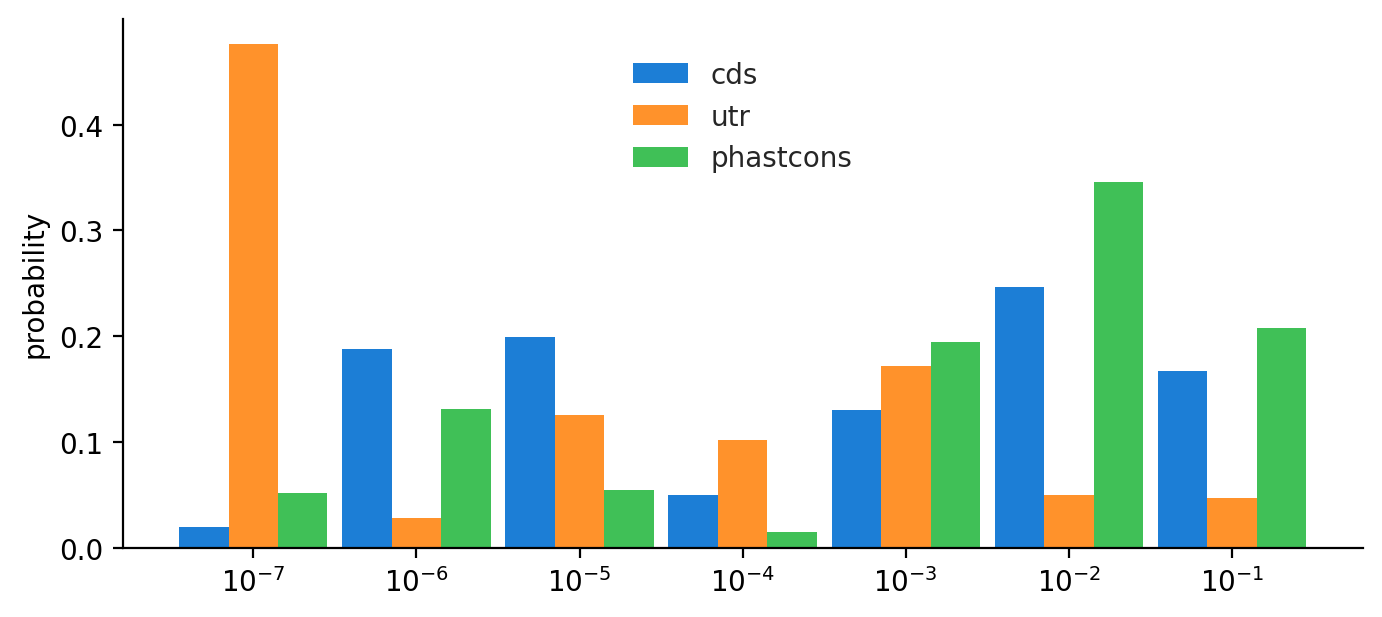

In [16]:
fit = bpfit_sm
xt = np.log10(fit.t)

fig, ax = plt.subplots()

w = 1/3-0.03
hw = w/2
ax.bar(xt-w-hw, fit.mle_W[:, 0], align='edge', width=w, label='cds')
ax.bar(xt-hw, fit.mle_W[:, 2], align='edge', width=w, label='utr')
ax.bar(xt+w-hw, fit.mle_W[:, 1], align='edge', width=w, label='phastcons')

ax.set_xticks(np.log10(fit.t), [f"$10^{{{int(x)}}}$" for x in xt])
ax.set_ylabel('probability')
ax.legend()

### Rescaling

After the MLE is estimated, we get a predicted B(x) map. We can use the local B(x) in the system of equations we solve for B and the ratchet rate; this is the "local rescaling" step since the single $N_e$ is rescaled locally along the genome.

What is the distribution of the local rescaling factors (e.g. B) across segments? 

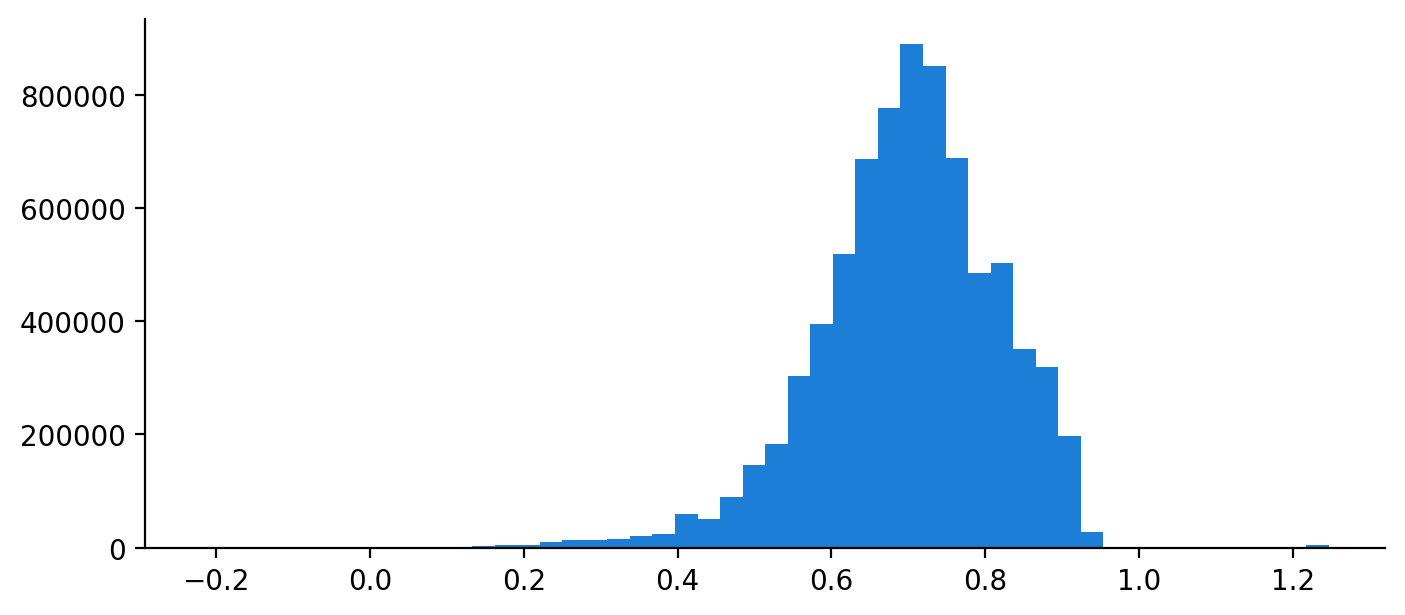

In [17]:
_ = plt.hist(mf.genome.segments.rescaling, 50)

In [18]:
mf.genome.segments.rescaling.mean()

0.6998490873081481

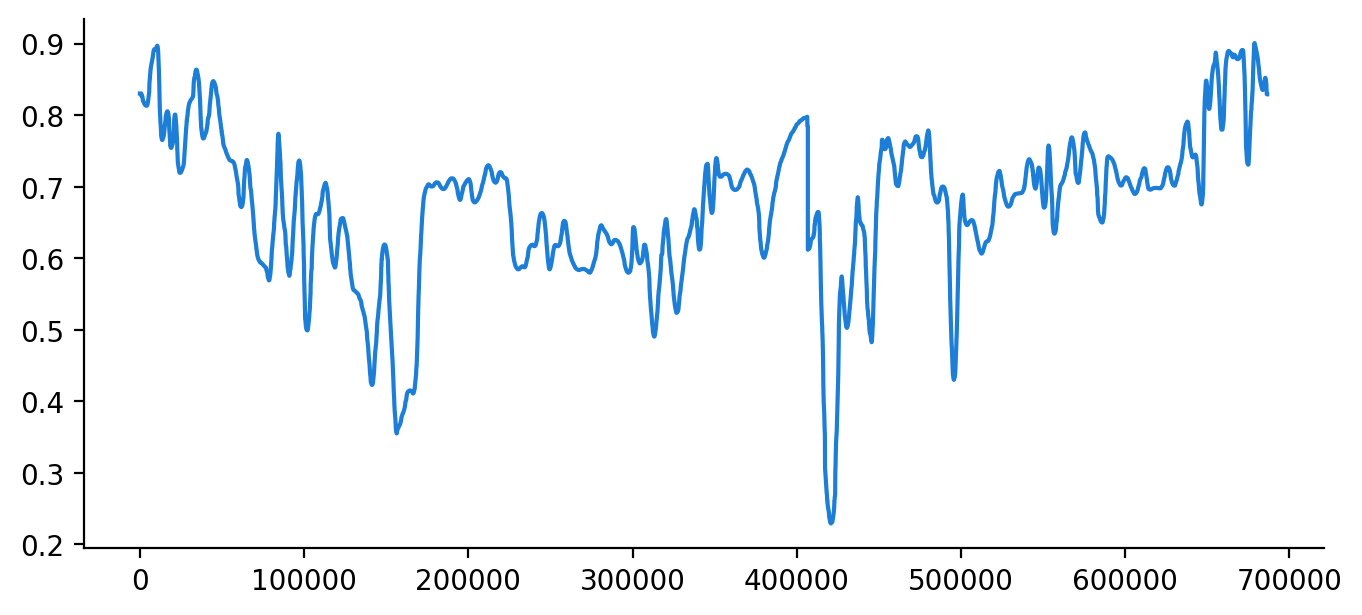

In [19]:
plt.plot(mf.genome.segments.rescaling[mf.genome.segments.index['chr1']])

How does the locally-rescaled B' differ from unscaled one?

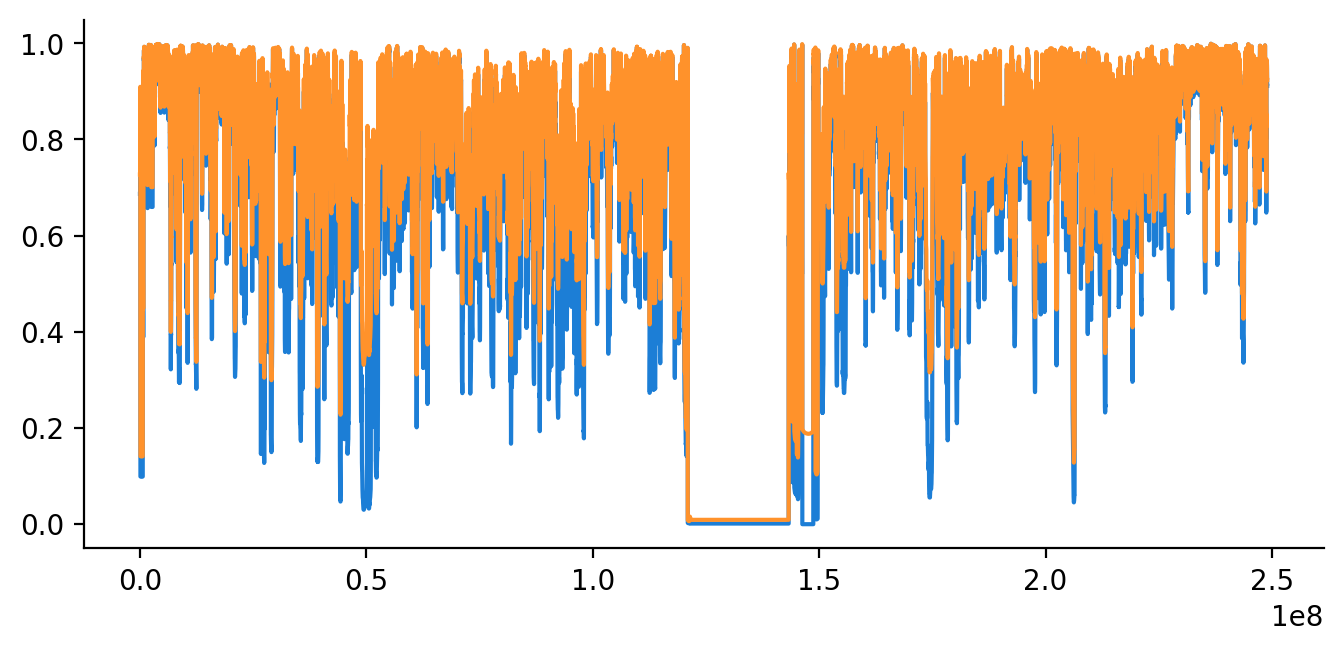

In [20]:
x, y = m.BpScores.pairs('chr1', m.w[4], 1e-4)
plt.plot(x, y[:, 1])

x, y = mf.BpScores.pairs('chr1', mf.w[4], 1e-4)
plt.plot(x, y[:, 1])

### Raw Predicted Substitution Rates and Rescaled Rates

In [236]:
cols = ('chrom', 'start', 'end', 'feature', 'R', 'r', 'r_nbases', 'load_region')

dsr = pd.read_csv('../data/phylo/ratchet_data.bed', sep='\t',
                 names=cols)
cols = ('chrom', 'start', 'end', 'feature', 'R_rs', 'r_rs', 'r_rs_nbases', 'load_region')

dsr_rs = pd.read_csv('../data/phylo/ratchet_rescaled_data.bed', sep='\t',
                 names=cols)

### Binned Ratchet Rates and phylFit Estimates (Megabase)

We load the rescaled predictions.

In [21]:
cols = ('chrom', 'start', 'end', 'R', 'r_rs', 'r_rs_bases')
r1Mb = pd.read_csv('../data/phylo/ratchet_rescaled_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')
r1Mb['midpoint'] = 0.5*(r1Mb['start'] + r1Mb['end'])

cols = ('chrom', 'start', 'end', 'R', 'branch_length', 'ml_bases')
pf1Mb = pd.read_csv('../data/phylo/phylofit_rates_binned_1000000.bed', names=cols,
                   na_values='.', sep='\t')
pf1Mb['midpoint'] = 0.5*(pf1Mb['start'] + pf1Mb['end'])

### Uricchio et al (2019) Substitution Data

From [this paper](https://www.nature.com/articles/s41559-019-0890-6). See the `data/phylo/Snakefile` for more information on how this is processed. 

Since we want the proportion of subsitutions and the Urrichio data doesn't have the number of codons considered, I joined Uricchio's data with the Ensembl canonical transcript CDS lengths.

This dataset also has the phylofit substitution rates joined in.

The raw Uricchio data (`../data/phylo/41559_2019_890_MOESM3_ESM.txt`) has columns:
   
1. Ensembl coding gene ID
2. Number of non-synonymous polymorphic sites
3. Respective derived allele frequencies of these sites separated by commas
4. Number of synonymous polymorphic sites. 
5. Respective frequencies derived allele frequencies of these sites.
6. Number of fixed non-synonymous substitutions on the human branch.
7. Number of fixed synonymous substitutions on the human branch. 

In [22]:
cols = [
    "chrom",
    "start",
    "end",
    "gene_id",
    "n_nonsyn",
    "n_syn",
    "fixed_nonsyn",
    "fixed_syn",
    "dnDs",
    "total_fixed",
    "len",
    "cai",
    "gc",
    "gc3",
    "syn_prop",
    "nonsyn_prop",
    "total_prop",
    "dNdS",
    'S', 
    'N',
    "r",
    "r_nbases",
    "r_rs", "r_rs_nbases",
    "branch_length",
    "bl_nbases",
    
]

d = pd.read_csv('../data/phylo/uricchio_data_merged.bed', sep='\t', na_values='.', names=cols)
d['width'] = d['end'] - d['start']
d['midpoint'] = 0.5*(d['start'] + d['end'])

In [23]:
d.head()

chrom   start     end          gene_id  n_nonsyn  n_syn  fixed_nonsyn  \
0  chr1  923923  944575  ENSG00000187634        28     21             8   
1  chr1  944203  959309  ENSG00000188976        31     32             4   
2  chr1  960584  965719  ENSG00000187961        11     28             0   
3  chr1  966482  975865  ENSG00000187583        47     19             0   
4  chr1  975198  982117  ENSG00000187642        31     22            11   

   fixed_syn      dnDs  total_fixed  ...           S            N  \
0          4  2.000000           12  ...  677.333333  1854.666667   
1          8  0.500000           12  ...  524.666667  1722.333333   
2          8  0.000000            8  ...  484.000000  1442.000000   
3          3  0.000000            3  ...  473.666667  1359.333333   
4          3  3.666667           14  ...  626.000000  1744.000000   

              r  r_nbases          r_rs  r_rs_nbases  branch_length  \
0  1.213545e-08    2653.0  8.610962e-09         4658       0.009005   
1  1.213500e-08    2231.0  9.234576e-09         2950       0.009129   
2  1.213586e-08    1548.0  1.012162e-08         2776       0.009129   
3  1.213590e-08    1977.0  9.110700e-09         3800       0.009129   
4  1.214276e-08    2370.0  1.038721e-08         4203            NaN   

   bl_nbases  width  midpoint  
0    96703.0  20652  934249.0  
1    55542.0  15106  951756.0  
2    55542.0   5135  963151.5  
3    55542.0   9383  971173.5  
4        NaN   6919  978657.5  

[5 rows x 28 columns]

In [24]:
for chrom in d.chrom.unique():
    d.loc[d['chrom'] == chrom, 'B'] = bpfit.predict_B_at_pos(chrom, d.loc[d['chrom'] == chrom, 'midpoint'])

Some summary statistics on the lengths of genes, and number of bases used for estimates:

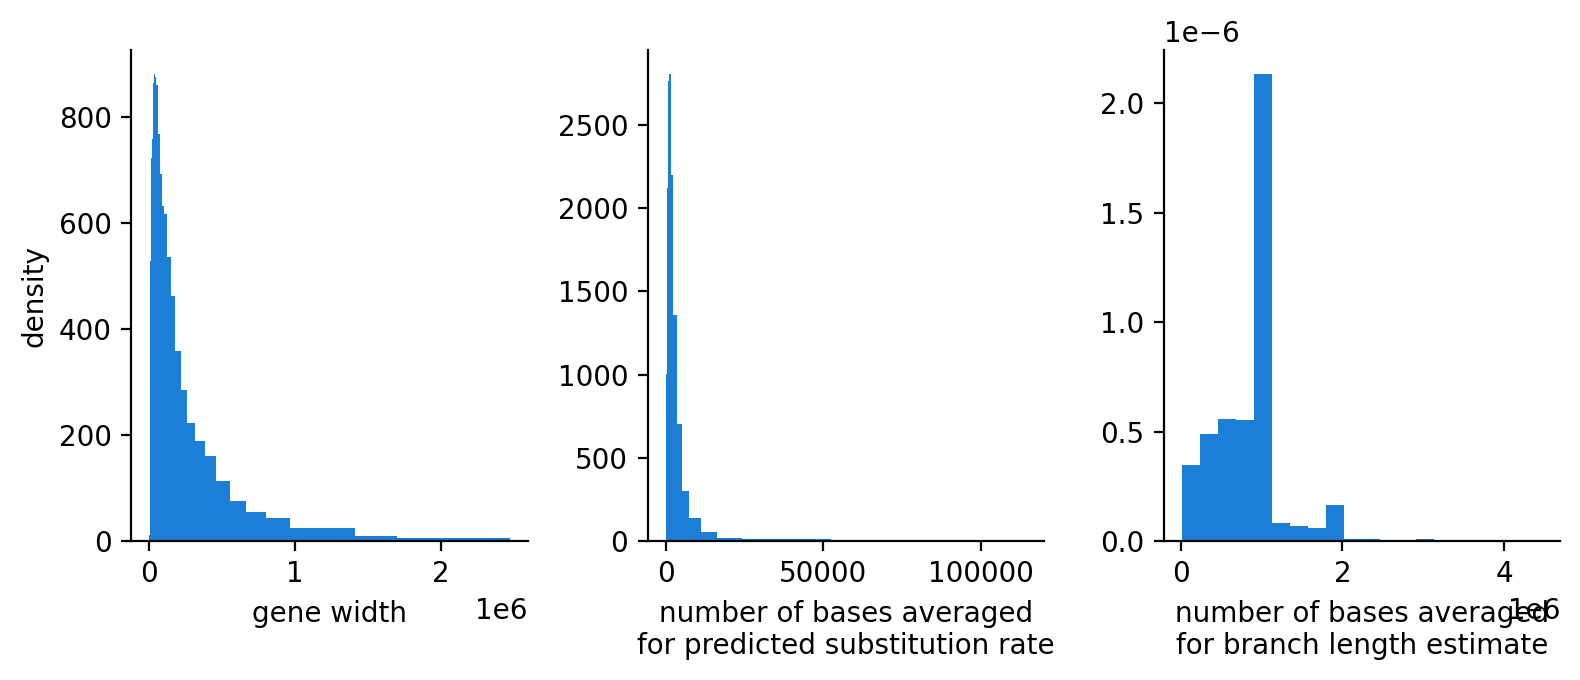

In [25]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

What's the correspondance between phylofit branch lengths and Uricchio's substitution proportions?

In [26]:
corr(d['branch_length'], d['total_prop'])

((0.1674625136298407, 4.4498990795268144e-85),
 SpearmanrResult(correlation=0.206790854125823, pvalue=1.1222011876070762e-129))

In [27]:
corr(d['branch_length'], d['syn_prop'])

((0.14806506559564211, 1.0246408682489994e-66),
 SpearmanrResult(correlation=0.1699826587436179, pvalue=1.2268769265975793e-87))

In [28]:
corr(d['branch_length'], d['nonsyn_prop'])

((0.12684957228228788, 2.6212014059155865e-49),
 SpearmanrResult(correlation=0.13419846333442986, pvalue=5.0316817080962134e-55))

There are correlated, but different. The estimates from phyloFit are **not** subset by feature, and are thus noiser because they mix features under different levels of constraint. The main analysis focuses just on the gene substitution rates from Uricchi et al.

#### Comparison Between PhyloFit and Substitutions from Uricchio et al.

Now let's look at the phyloFit branch length estimates.

Text(0.5, 0, 'predicted substitution rate')

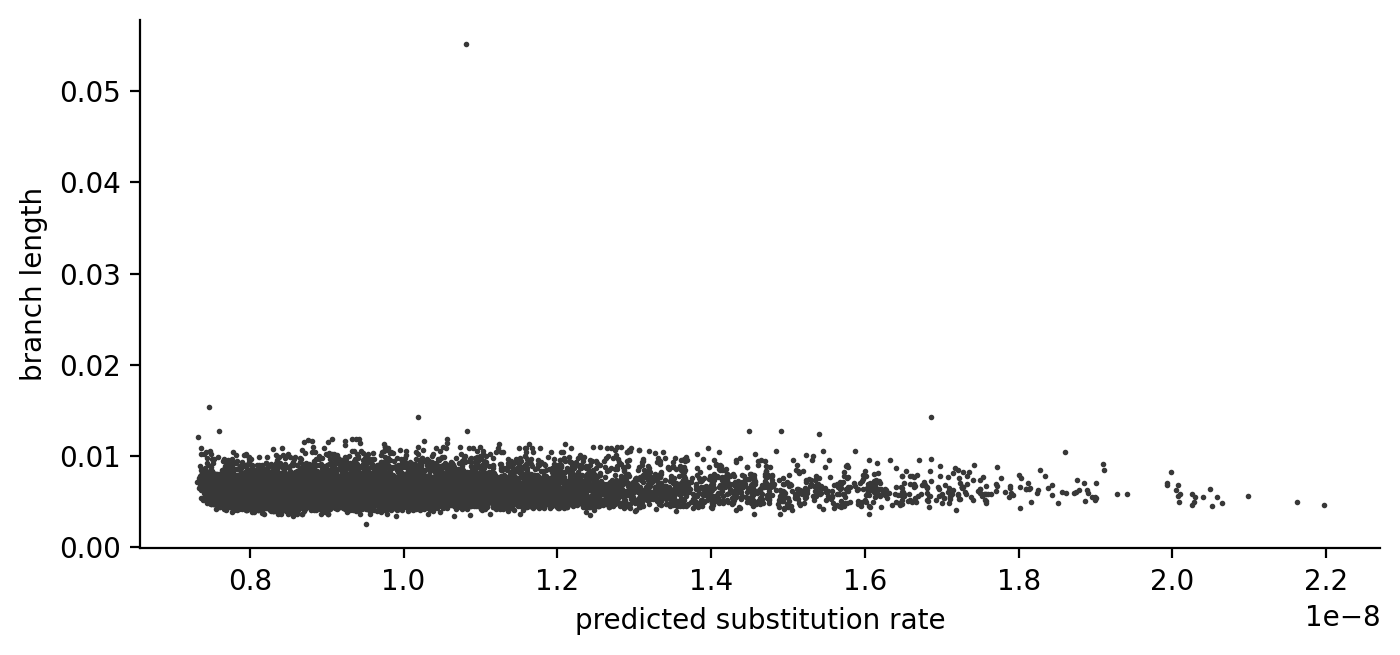

In [29]:
fig, ax = plt.subplots()
ax.scatter(d['r_rs'], d['branch_length'], c='0.22', s=1, alpha=1)
ax.set_ylabel('branch length')
ax.set_xlabel('predicted substitution rate')

One outlier, but the trend is interesting. Let's compare the trends between this and the total CDS substitution rate.

Note that the branch length estimates are **very approximate** — because the substitutions are not directly counted **in the region** but are estimated from the overlapping branch rates of all overlapping alignments (even those of different features).

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(<Figure size 1600x700 with 1 Axes>, <AxesSubplot: >)

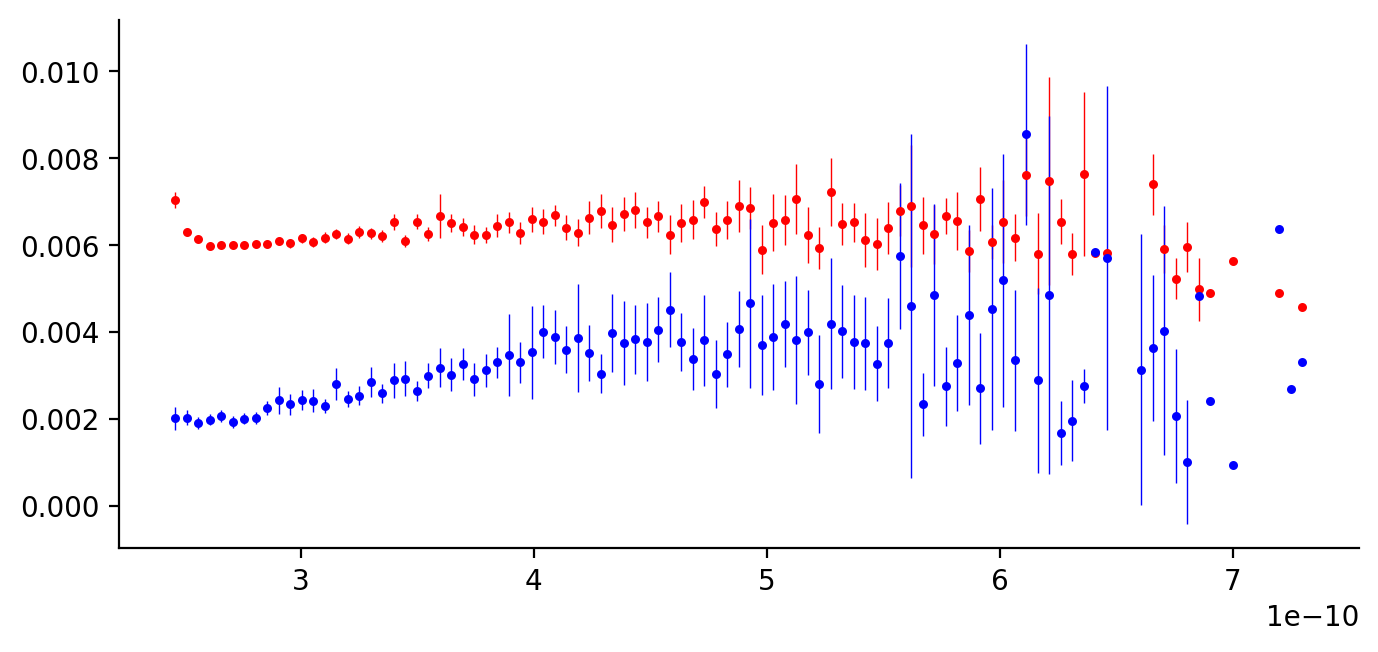

In [30]:
fig, ax = plt.subplots()
binned_means_plot(binned_summaries(d['r_rs']/30, d['branch_length'], 100), figax=(fig, ax), c='r')
binned_means_plot(binned_summaries(d['r_rs']/30, d['total_prop'], 100), figax=(fig, ax), c='b')

We see the same trend — higher predicted substitution rates, higher branch length estimates. The rates are higher due to more UTRs, introns, etc that also aligned.  Note the uptick — I've seen this a few times, and it could be that adaptive rates are higher when the substitution rates are lower (e.g. lower HRI). This will require further investigation though.

#### Outlier Filtering

There are a few extreme outliers we remove.

(array([6190., 4742., 2611., 1317.,  688.,  392.,  254.,   88.,   27.,
           7.]),
 array([7.31000408e-09, 8.77596070e-09, 1.02419173e-08, 1.17078739e-08,
        1.31738306e-08, 1.46397872e-08, 1.61057438e-08, 1.75717004e-08,
        1.90376570e-08, 2.05036137e-08, 2.19695703e-08]),
 <BarContainer object of 10 artists>)

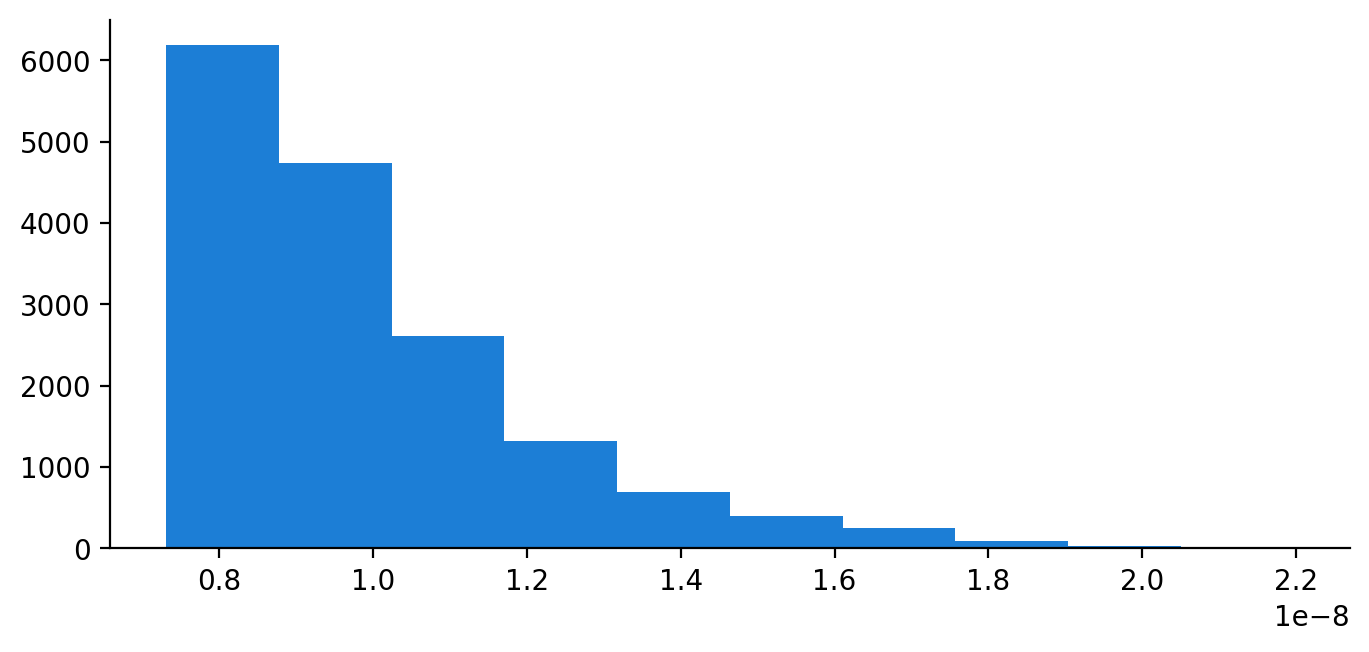

In [130]:
plt.hist(d['r_rs'])

Text(0.5, 0, 'predicted substitution rate')

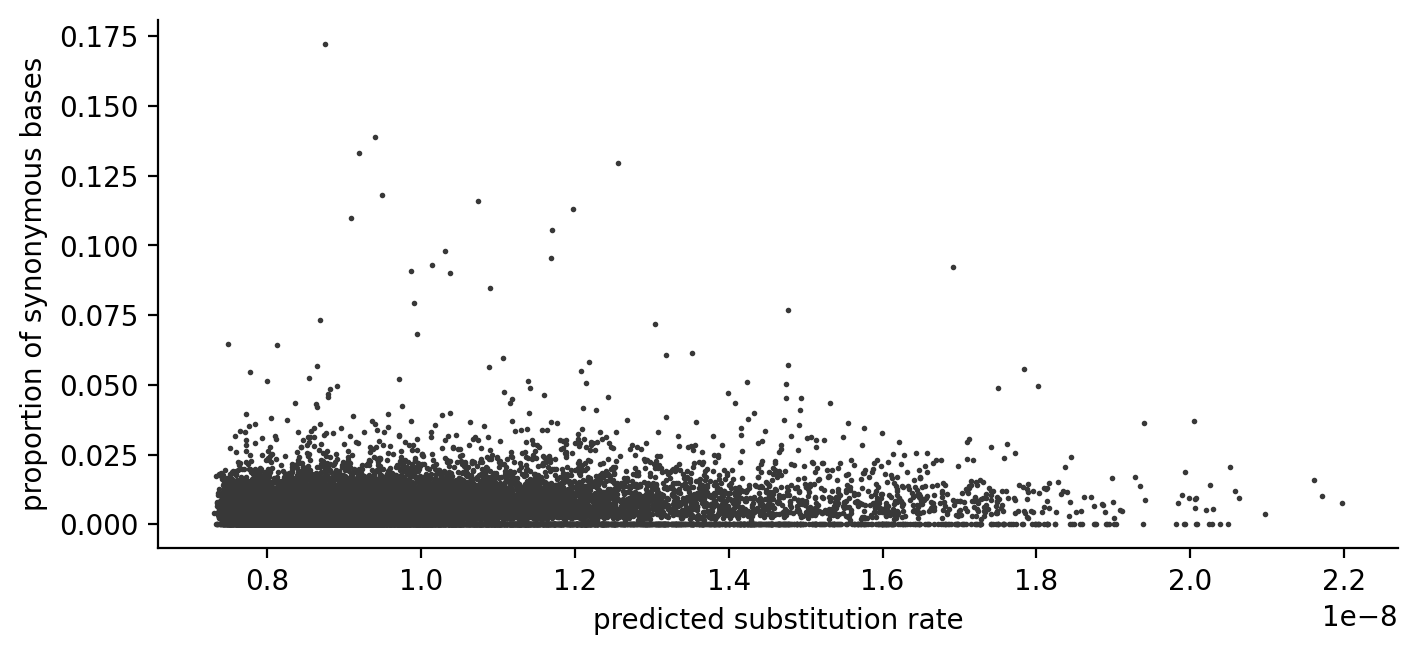

In [31]:
fig, ax = plt.subplots()
ax.scatter(d['r_rs'], d['syn_prop'], c='0.22', s=1, alpha=1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

Text(0.5, 0, 'predicted substitution rate')

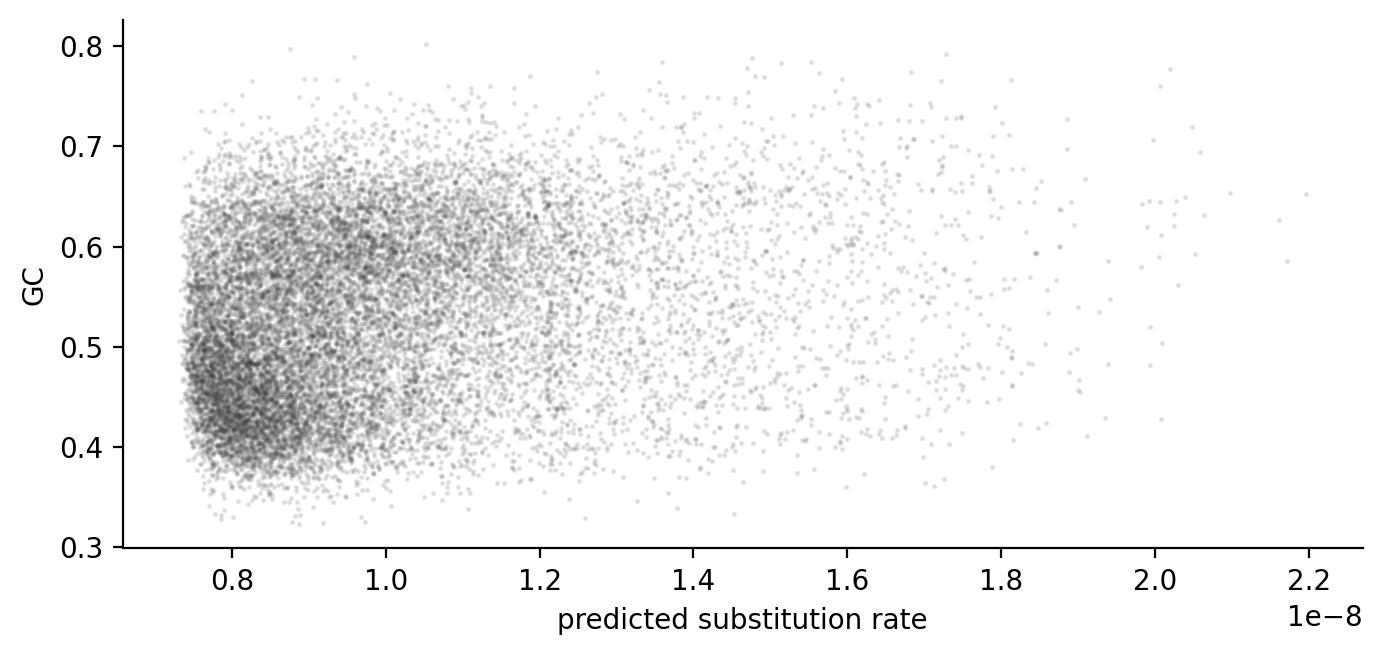

In [71]:
fig, ax = plt.subplots()
ax.scatter(d['r_rs'], d['gc'], c='0.22', s=1, alpha=0.1)
ax.set_ylabel('GC')
ax.set_xlabel('predicted substitution rate')

Now let's look at predicted substitution rates across the chromosomes:

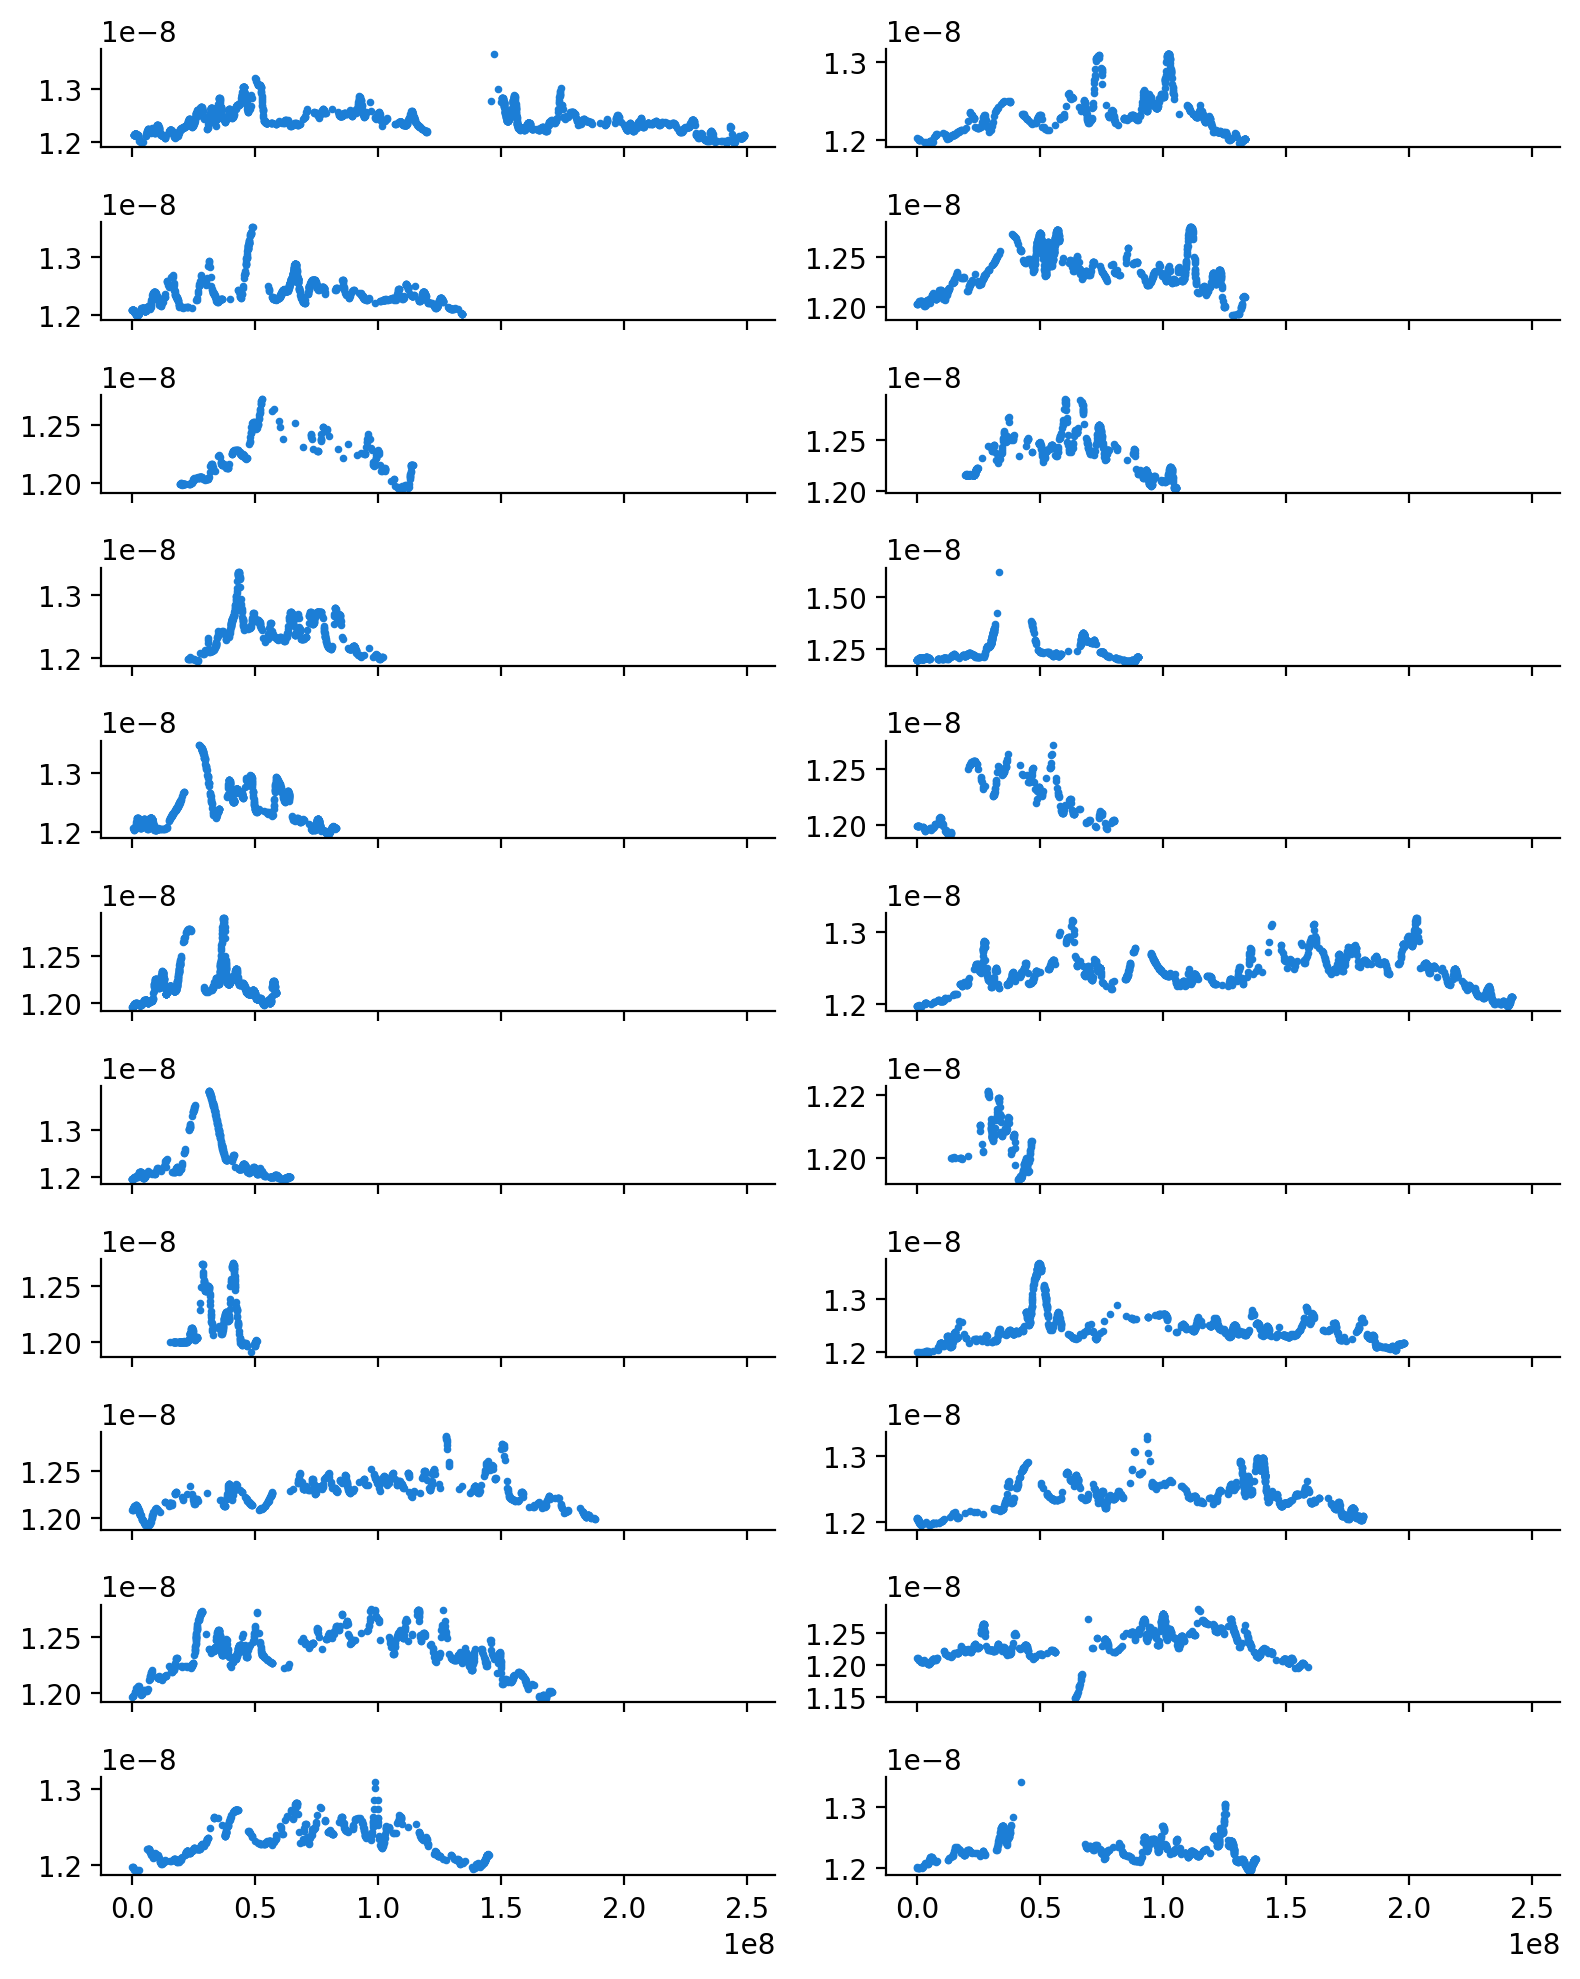

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['r'], s=3)
    
plt.tight_layout()

Now let's look at branch length (from PhyloFit) in the Urrichio et al data along the genome. Immediately we see some very strong outliers that we remove.

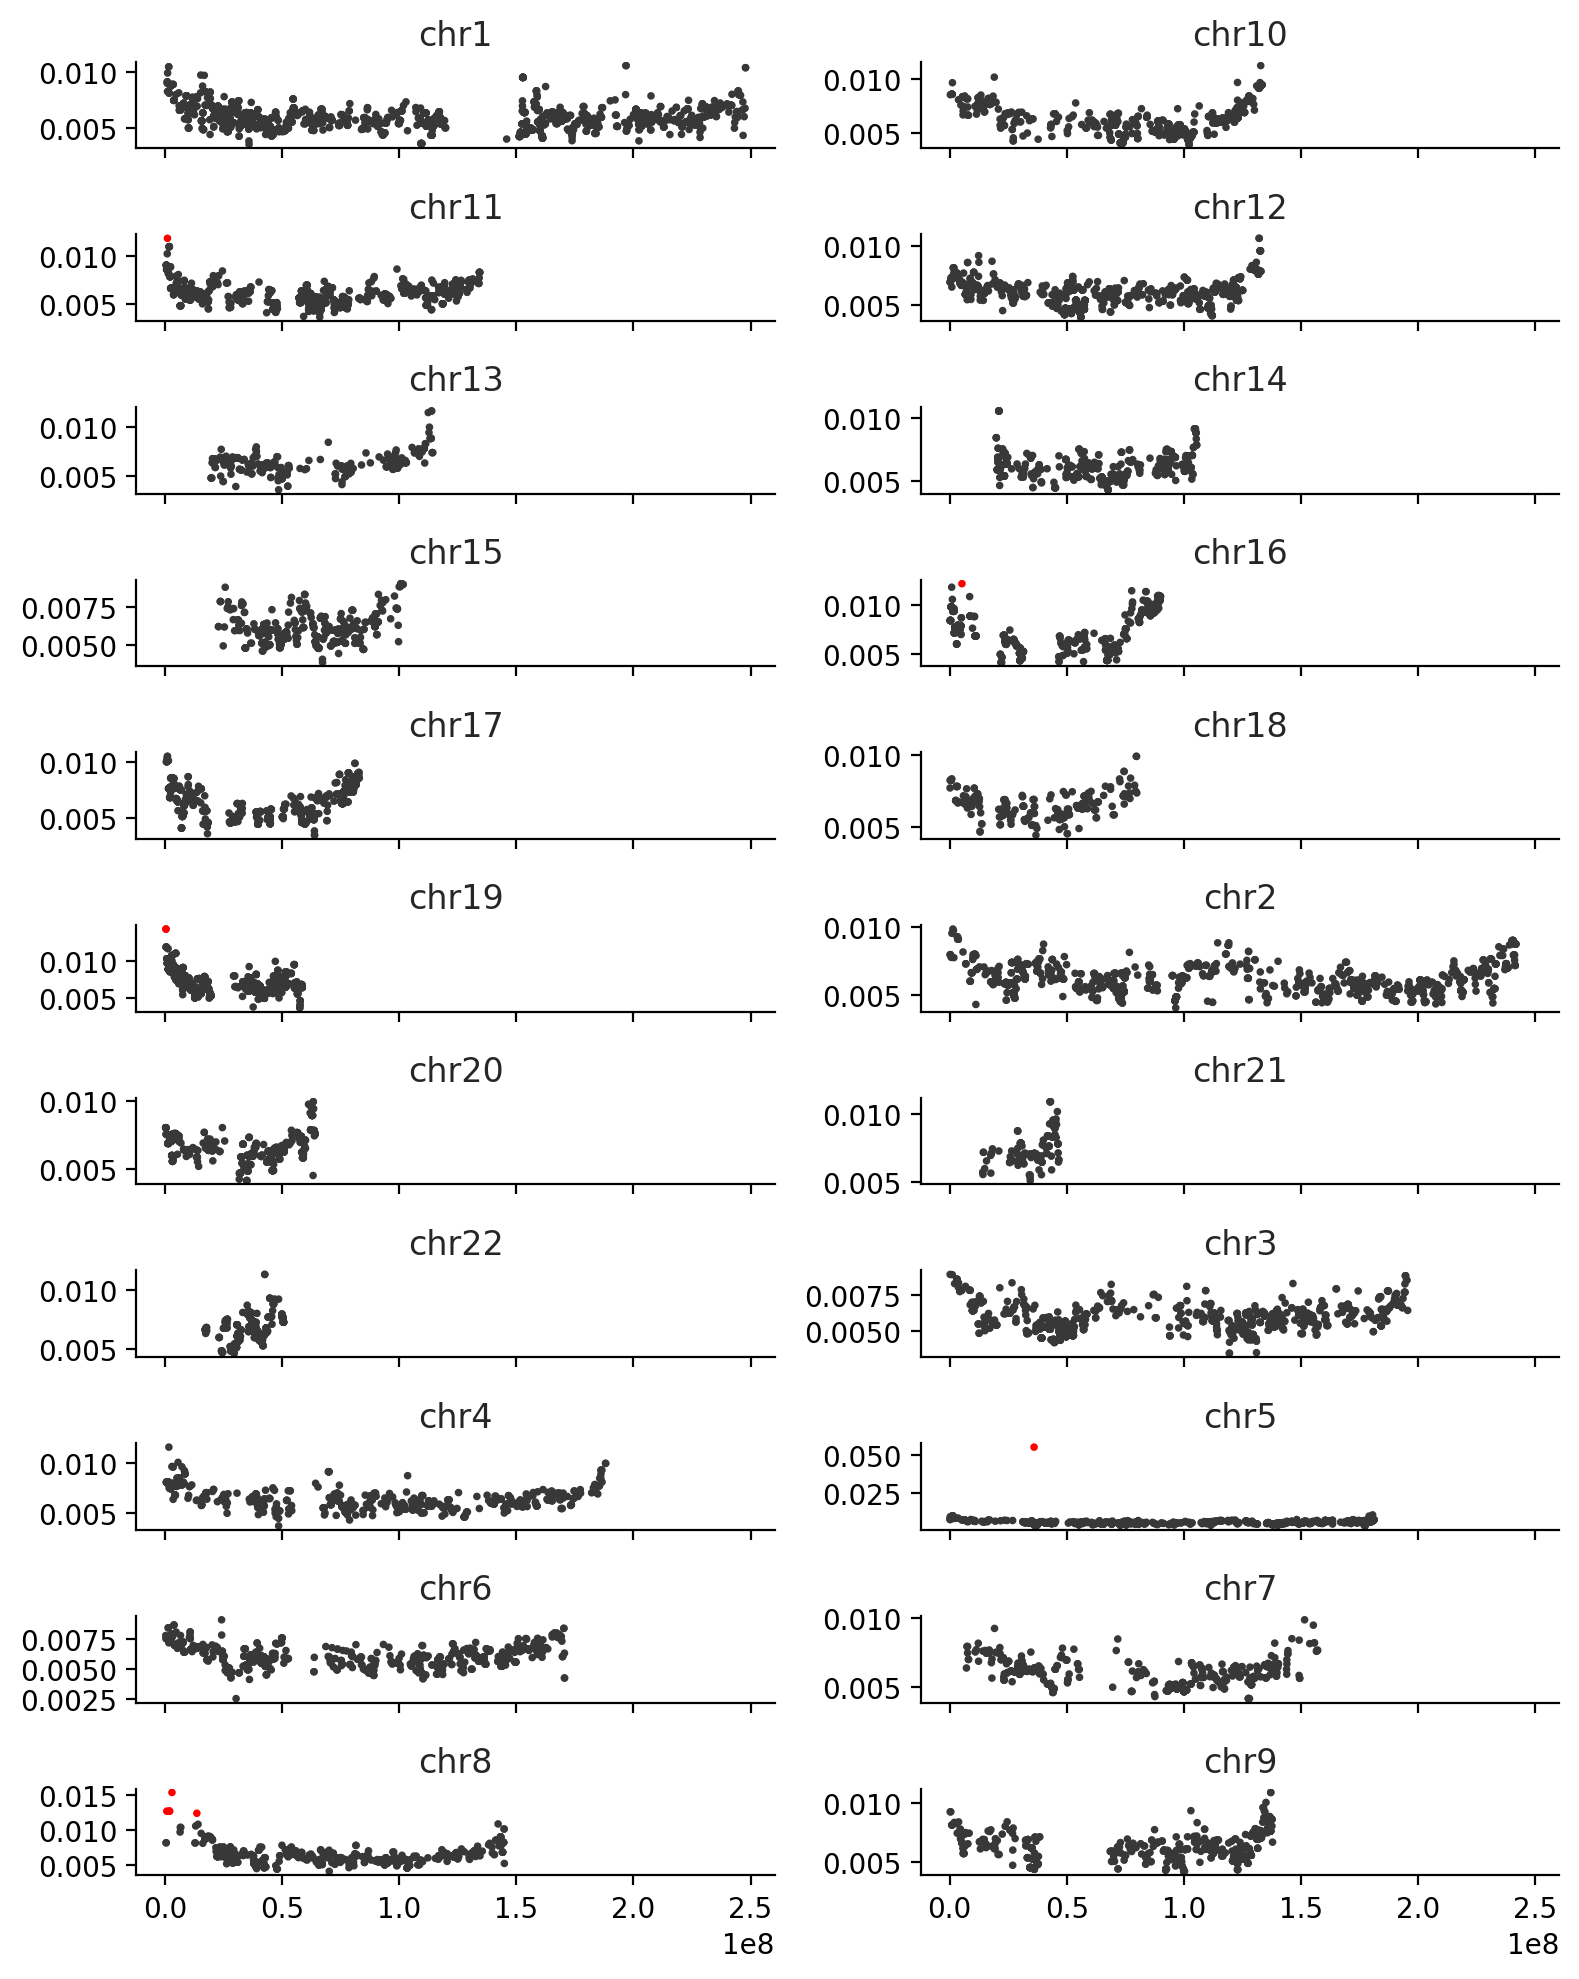

In [33]:
thresh = np.nanquantile(d['branch_length'], 0.999)

fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

for i, chrom in enumerate(d['chrom'].unique()):
    dx = d.loc[d['chrom'] == chrom]
    exclude = dx['branch_length'] > thresh
    ax[rows.flat[i], cols.flat[i]].scatter(dx['start'], dx['branch_length'], c=[{True: 'r', False: '0.22'}[x] for x in exclude], s=3)
    ax[rows.flat[i], cols.flat[i]].set_title(chrom)
plt.tight_layout()

In [34]:
# mask out those high branch lengths
do = d.copy()
do.loc[(d['branch_length'] >= thresh), 'branch_length'] = np.nan

### Comparison of 1Mbp Binned Ratchet Rates with the phyloFit Binned Branch Lengths

Let's just look at the large-scale spatial patterns between predicted substitution rate and the estimated branch lengths from phyloFit, at the megabase scale.

Note that this is **confounded** by the density of features, meaning within a window the ratchet rate is an average over all features hypothesized to be under selection.



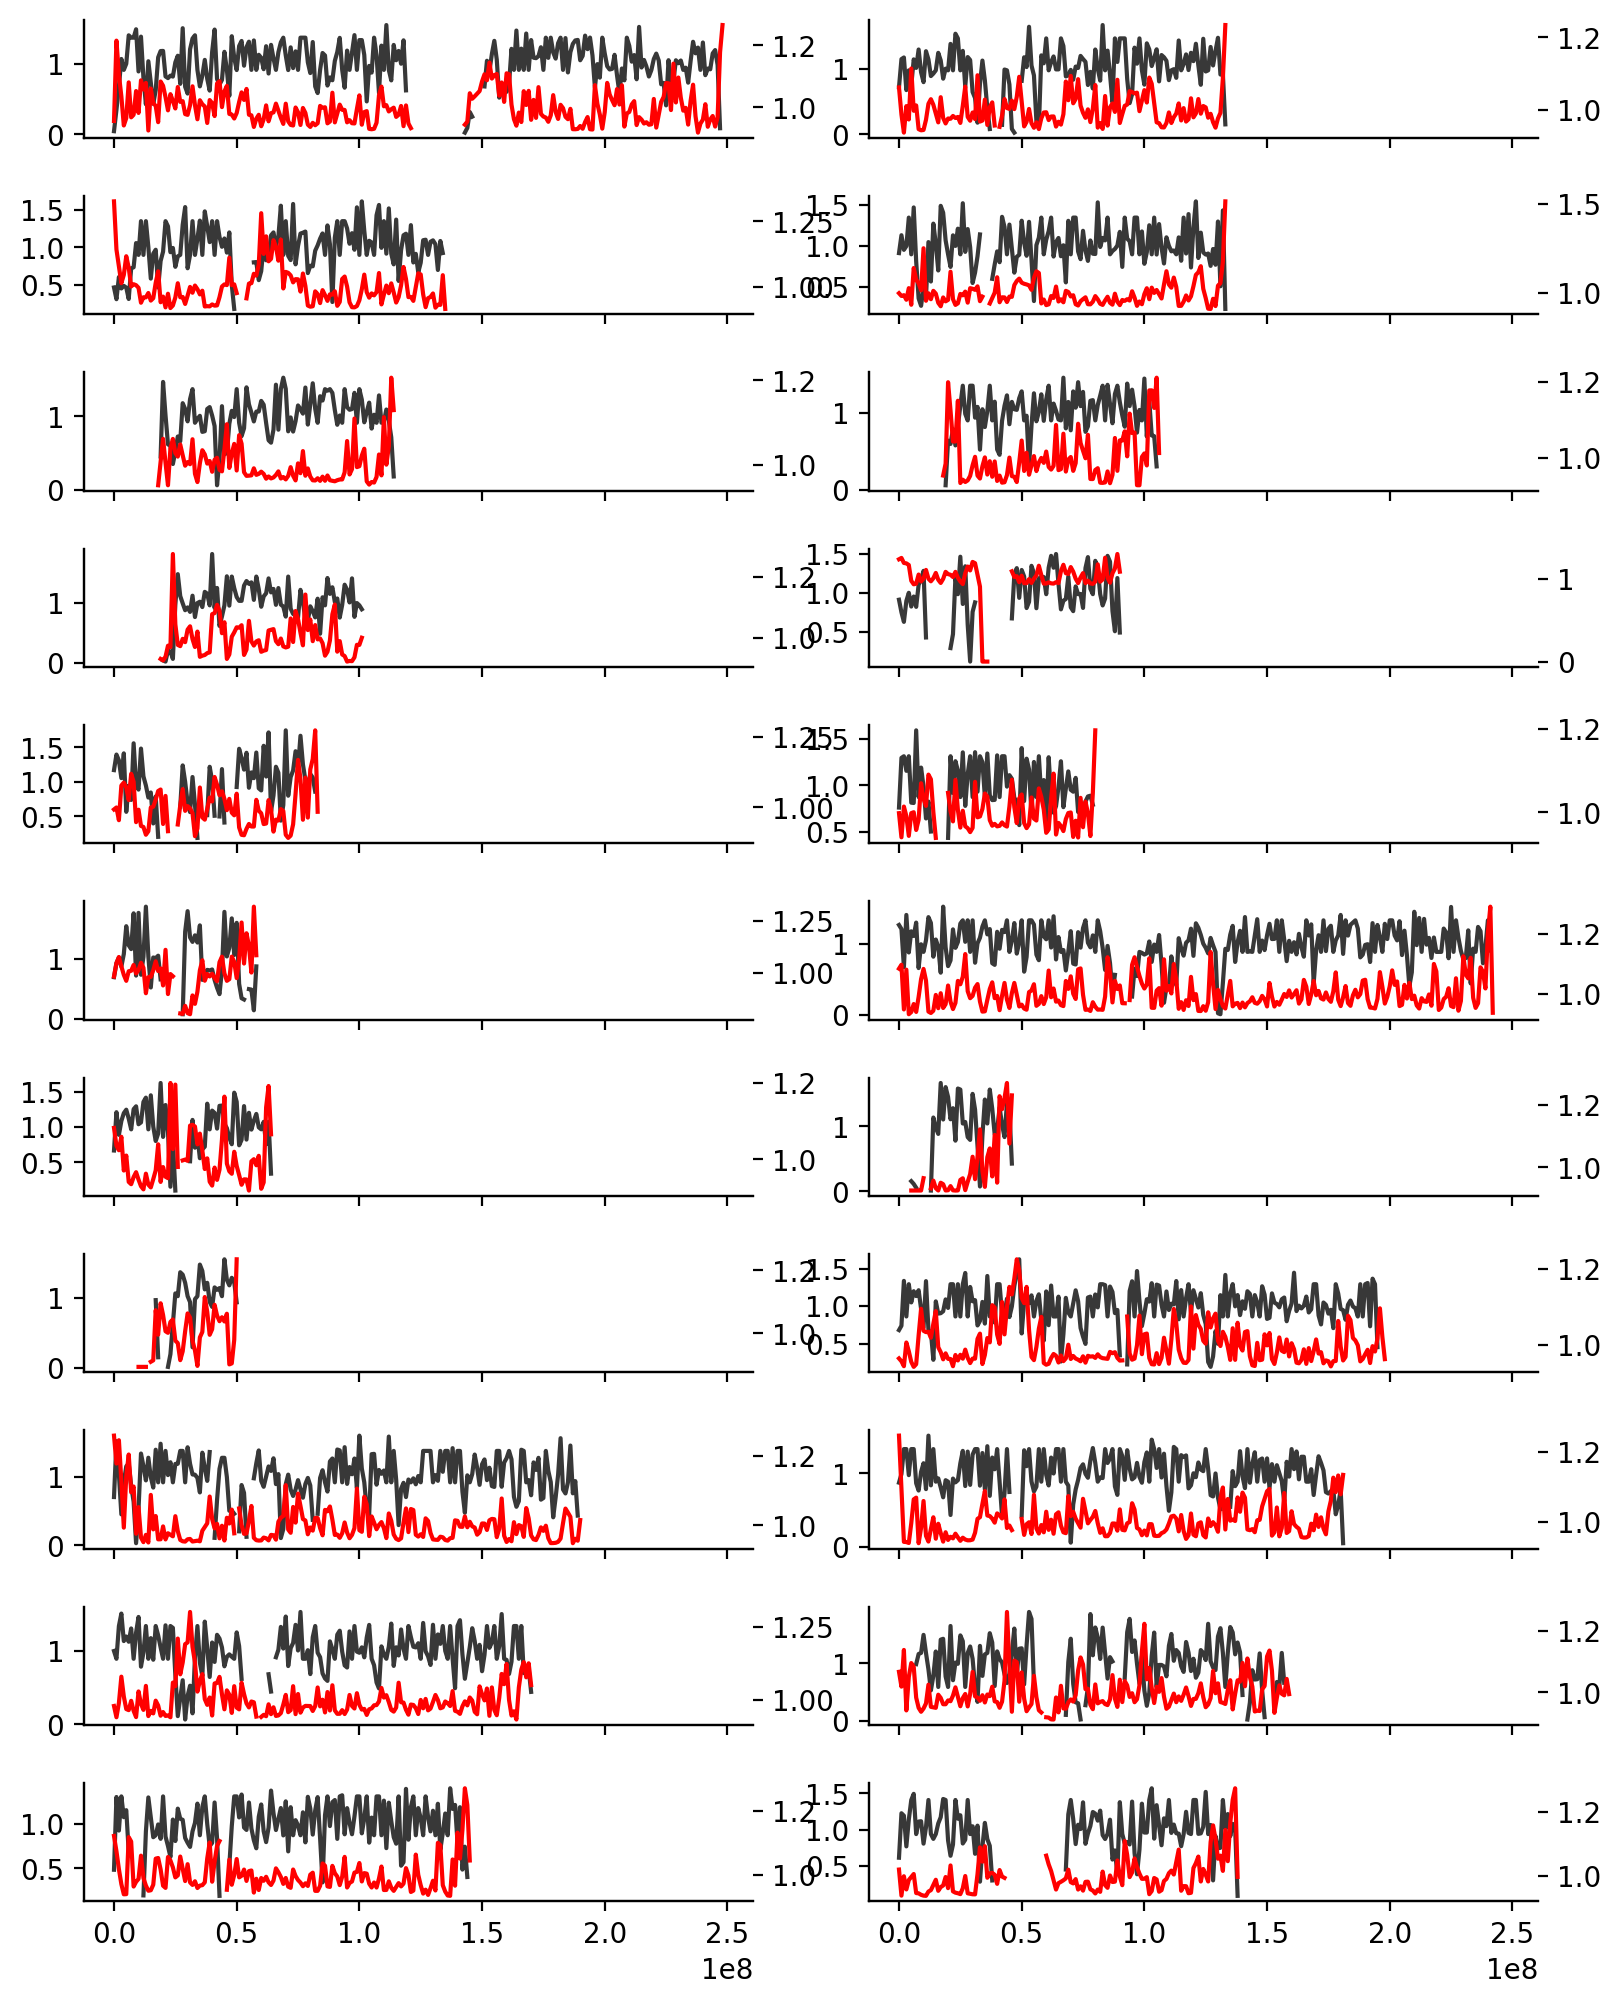

In [35]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 10), sharex=True)
plt.tight_layout()

cols, rows = np.meshgrid(np.arange(2), np.arange(11))

bls, pred_subs = [], []
for i, chrom in enumerate(do['chrom'].unique()):
    dx = pf1Mb.loc[pf1Mb['chrom'] == chrom]
    fax = ax[rows.flat[i], cols.flat[i]]
    fax.plot(dx['start'], mean_ratio(dx['branch_length']), c='0.22')
    ax2 = fax.twinx()
    
    rx = r1Mb.loc[r1Mb['chrom'] == chrom]
    ax2.plot(rx['start'], mean_ratio(rx['r_rs']), c='r', zorder=-1)
    bls.extend(dx['branch_length'])
    pred_subs.extend(rx['r_rs'])
    
    #rx = rd2_1Mbp.loc[rd2_1Mbp['chrom'] == chrom]
    #ax2.plot(rx['start'], mean_ratio(rx['r']), c='g', linestyle='dashed')


Text(0.5, 0, 'predicted substitution rate')

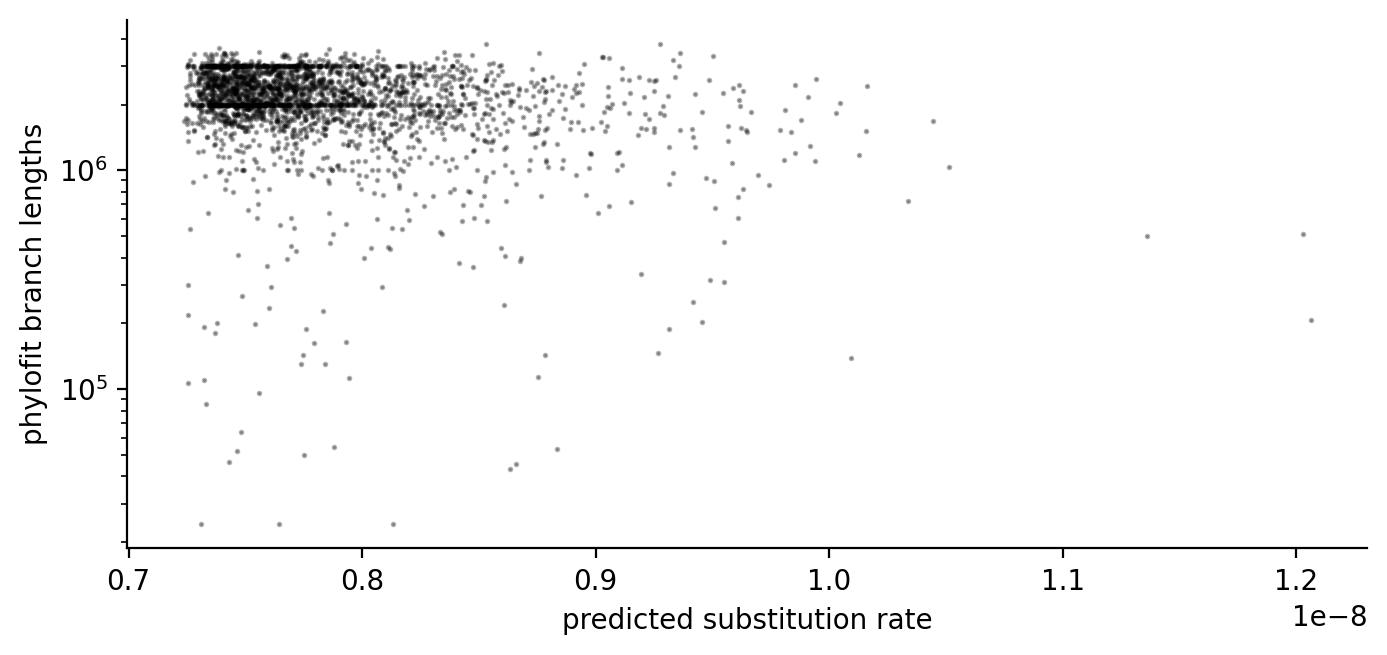

In [36]:
plt.scatter(pred_subs, bls, s=1, c='k', alpha=0.3)
plt.semilogy()
plt.ylabel('phylofit branch lengths')
plt.xlabel('predicted substitution rate')

Note the strange branch length estimates... this is most likely a large block being broken up, but needs further checks in the future. We don't use this data much...

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0, 'predicted substitution rate')

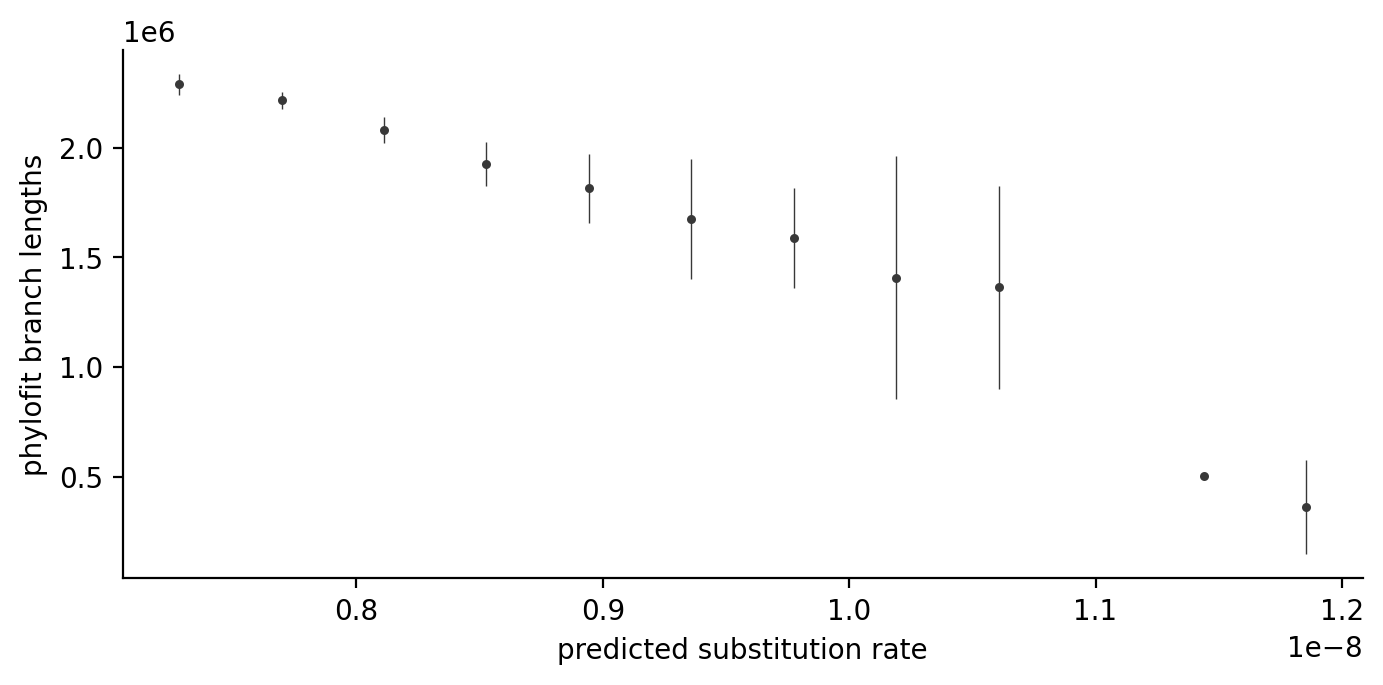

In [37]:
binned_means_plot(binned_summaries(pred_subs, bls, 30))
plt.ylabel('phylofit branch lengths')
plt.xlabel('predicted substitution rate')

Basically, there looks to be a significant but messy negative correlation across windows between predicted substitution rate and branch length.

In [40]:
corr(pred_subs, bls)

((-0.25589368560240244, 5.692109650846044e-40),
 SpearmanrResult(correlation=-0.2035772987534648, pvalue=1.3020772980369262e-25))

This is likely caused by confounding by the placement of conserved regions. For example, windows with more conserved regions have a higher prediction substitution rate, which puts these regions under selective constraint and causes a lower branch length. This confounding is why the gene-level analysis best, it compares the **segment (e.g. CDS) predicted substitution rate** with the **observed number of substitutions**.

### PhyloFit Branch Length Estimates

The raw phylofit data, see the `Snakefile` for how this is processed.

Note that the alignments are fairly large and between 10 primate species. The regions that can be aligned are likely under more contraint compared to regions that are not alignable. 

In [41]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)
p['width'] = p['end'] - p['start']

In [42]:
p.head()

chrom    start      end  branch_length  bl_nbases   width
0  chr1   917515   943305       0.008880      41161   25790
1  chr1   943306   972277       0.009129      55542   28971
2  chr1  1034538  1055058       0.006629      33328   20520
3  chr1  1055059  1167921       0.009928     459429  112862
4  chr1  1564774  1623511       0.010481     178850   58737

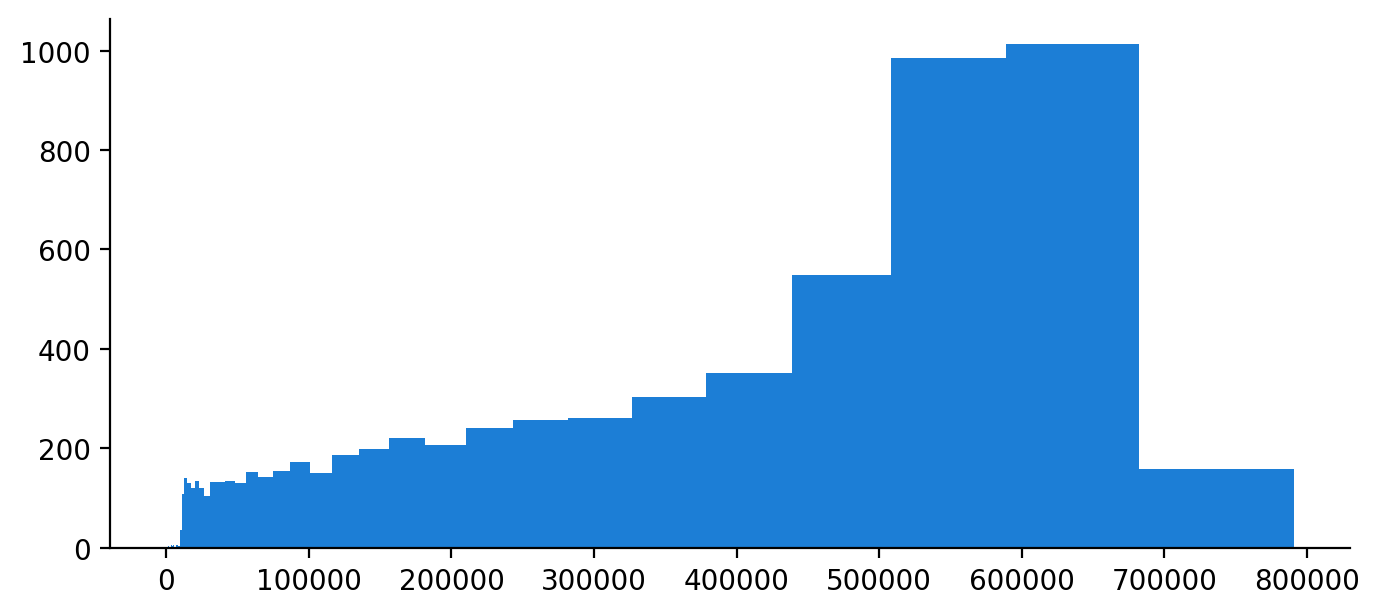

In [43]:
_ = plt.hist(*logbins(p['width'], 60))

[]

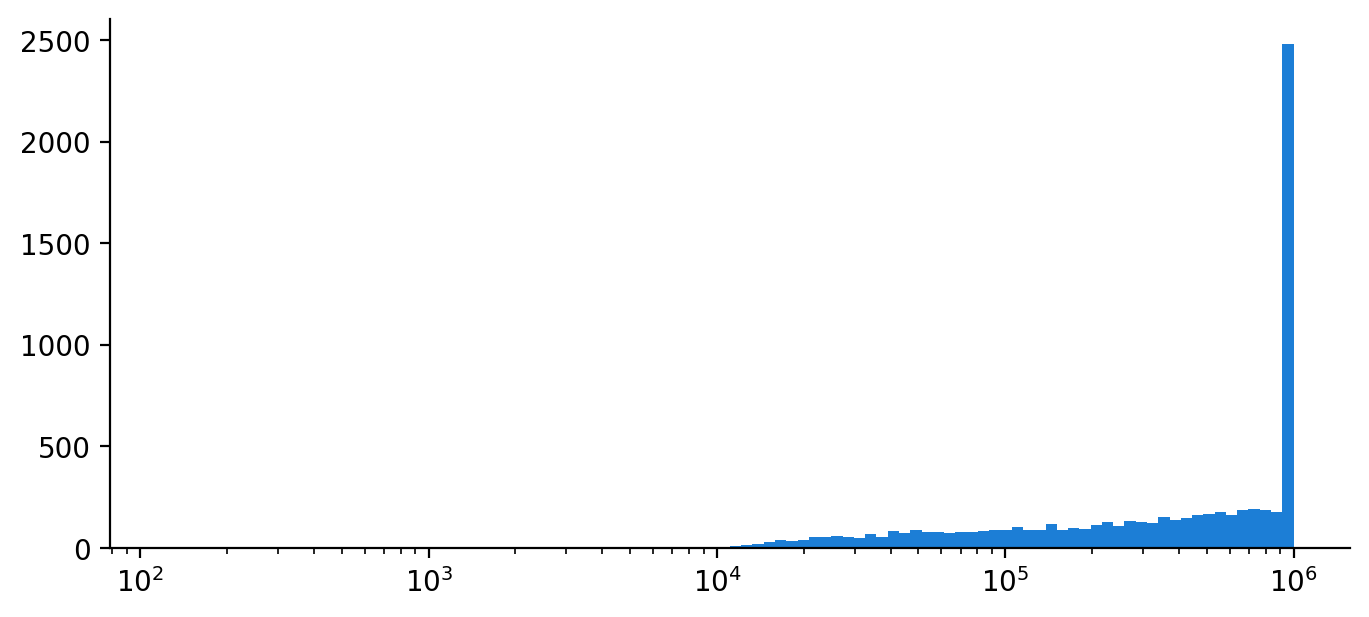

In [44]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [45]:
p['bl_nbases'].max()

1000000

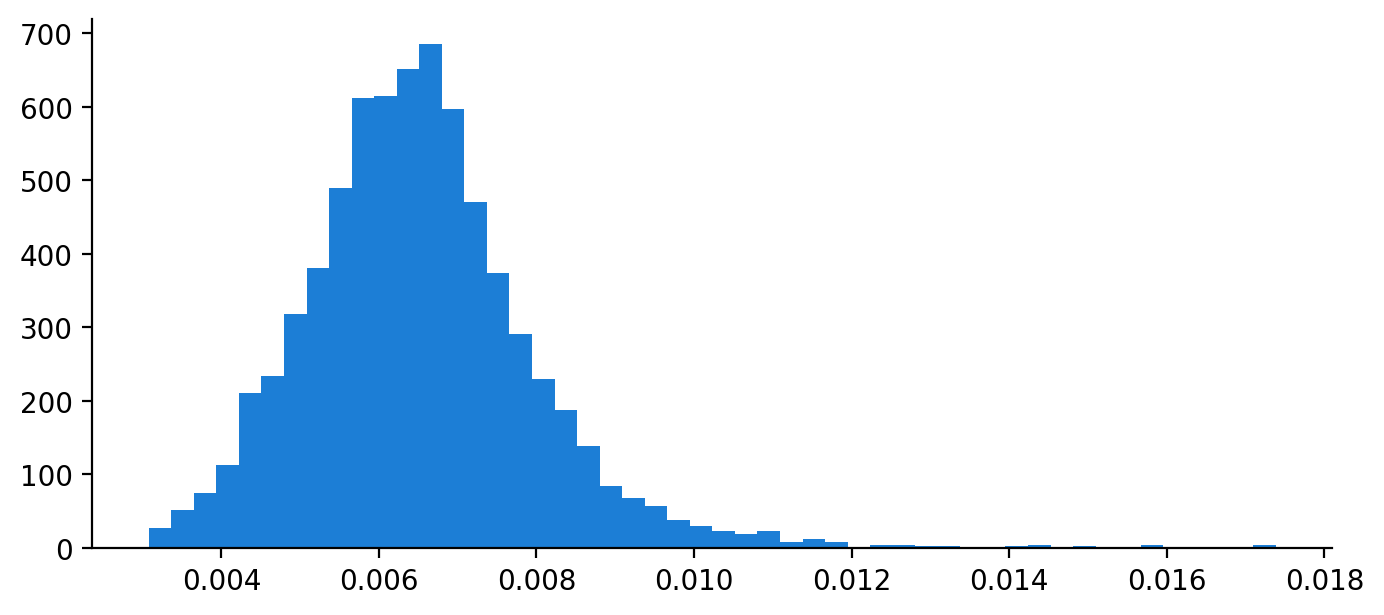

In [46]:
_ = plt.hist(censor(p['branch_length'], (0.001, 0.999)), 50)

## Gene-level Substitution Analysis and Parametric Models

I assume the generation time is $g = 30$ years/gen.

```
R subs/gen x 1/(g years/gen) = R/g subs/year
```

(This is all done by the units framework now...)


In [47]:
# the per-bp substitution rates are in subs/gen, we convert them here to mutations/year
do['r_year'] = np.array((do['r'].values * u.mutations/u.human_gen).to('mutations/year'))
do['r_rs_year']  = np.array((do['r_rs'].values * u.mutations/u.human_gen).to('mutations/year'))

In [48]:
x, x_rs, nonsyn_prop, syn_prop, total_prop, branch_length = do['r_year'], do['r_rs_year'], do['nonsyn_prop'], do['syn_prop'], do['total_prop'], do['branch_length']
b = do['B']

#keep = syn_prop > 0
#x_rs, syn_prop = x_rs[keep], syn_prop[keep]

[]

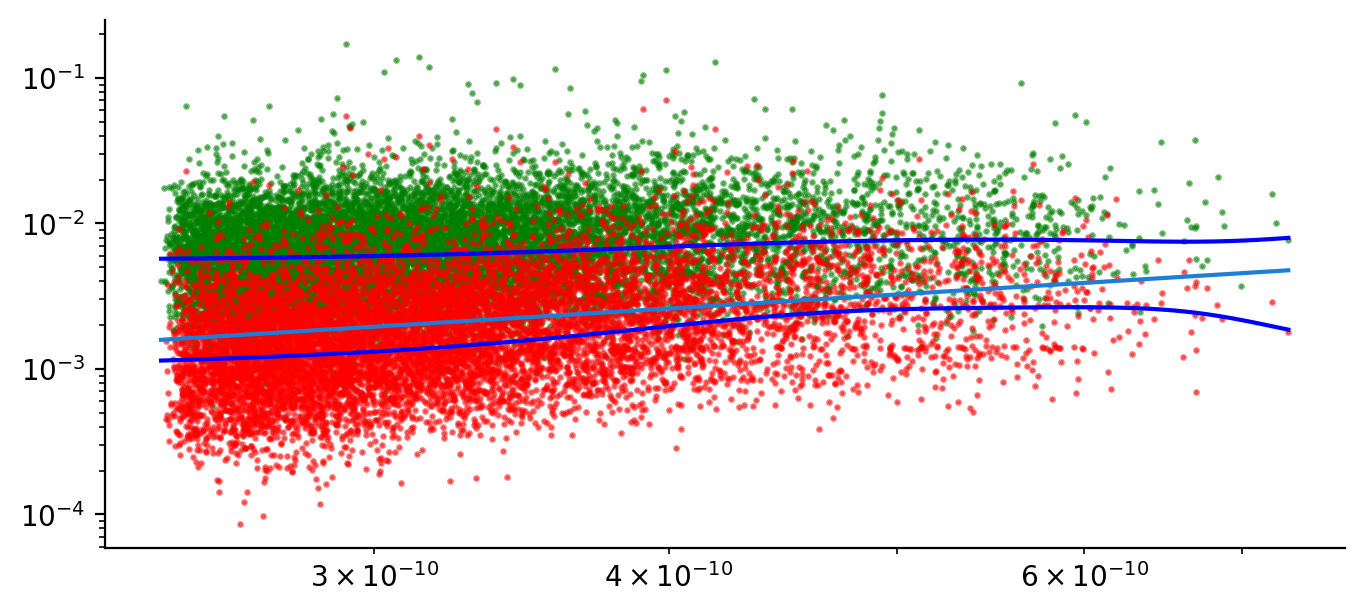

In [49]:
fig, ax = plt.subplots()

ax.scatter(x_rs, syn_prop, c='green', s=2, alpha=0.5)
ax.scatter(x_rs, nonsyn_prop, c='r', s=2, alpha=0.5)

xval = x_rs
rate_grid = np.linspace(xval.min(), xval.max(), 100)
ax.plot(rate_grid, KernelRegression(h=5e-11).fit(xval, syn_prop).predict(rate_grid), c='b')
#ax.plot(rate_grid, 6.5e6*rate_grid)

ax.plot(rate_grid, KernelRegression(h=5e-11).fit(xval, nonsyn_prop).predict(rate_grid), c='b')
ax.plot(rate_grid, 6.5e6*rate_grid)

ax.semilogx()
ax.semilogy()


[]

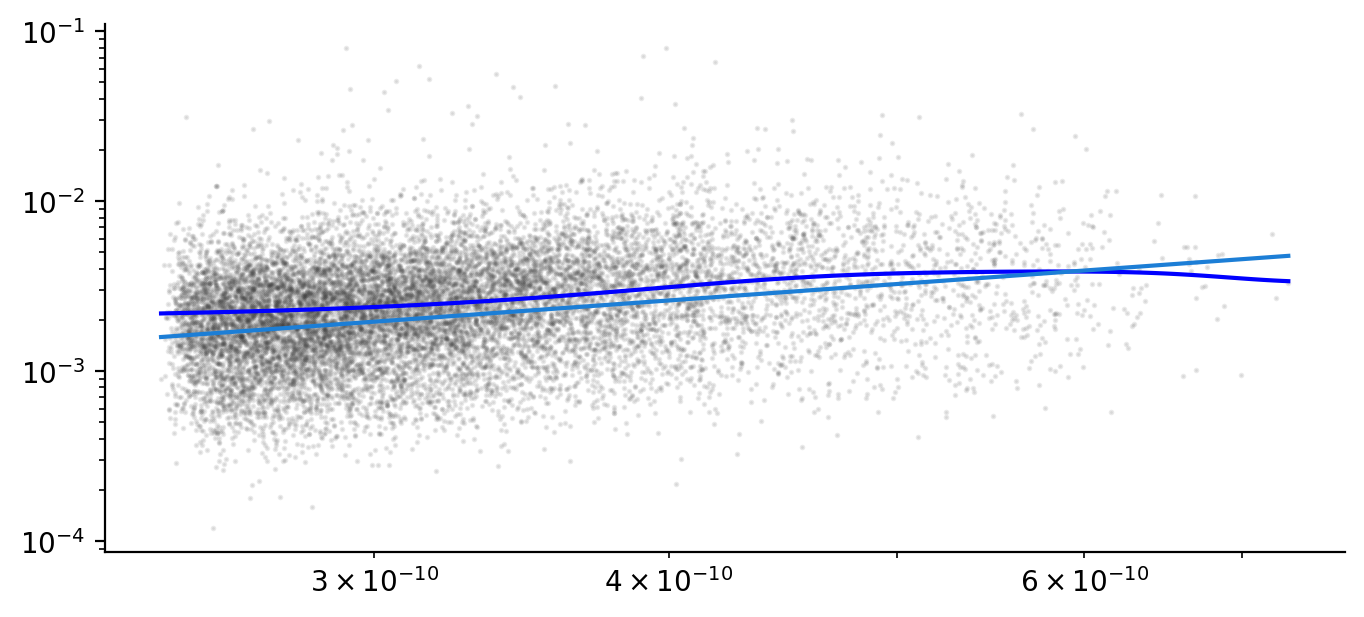

In [50]:
fig, ax = plt.subplots()

ax.scatter(x_rs, total_prop, c='0.22', s=1, alpha=0.1)

xval = x_rs
rate_grid = np.linspace(xval.min(), xval.max(), 100)
ax.plot(rate_grid, KernelRegression(h=5e-11).fit(xval, total_prop).predict(rate_grid), c='b')
ax.plot(rate_grid, 6.5e6*rate_grid)

ax.semilogx()
ax.semilogy()


### Correlations

In [64]:
corr(d['r_rs'], d['total_prop']), corr(d['r_rs'], d['syn_prop']), corr(d['r_rs'], d['nonsyn_prop'])

(((0.19107139860951688, 5.778145028491153e-134),
  SpearmanrResult(correlation=0.21099378519515583, pvalue=1.3945319861241544e-163)),
 ((0.0998517646057235, 1.9768893980340133e-37),
  SpearmanrResult(correlation=0.0635541347949618, pvalue=4.450703503892629e-16)),
 ((0.20396563833114864, 9.025041122028251e-153),
  SpearmanrResult(correlation=0.19152197348967517, pvalue=1.3393205066236933e-134)))

Now let's look at GC, which could be a confounder:

In [66]:
corr(d['r_rs'], d['gc']), corr(d['r_rs'], d['gc3'])

(((0.24377083143339068, 2.4066563670853273e-219),
  SpearmanrResult(correlation=0.2710308871959067, pvalue=1.2077960745688494e-272)),
 ((0.25331863628796886, 2.779543901530697e-237),
  SpearmanrResult(correlation=0.2871748309283591, pvalue=2.7111821192328593e-307)))

GC could be a confounder; our prediction accuracy could be an artifact of some other relationship. We explore this more below with linear fits.

#### Bootstrap CIs for Correlation

In [272]:
bs_spear = []
bs_pear = []

n = do.shape[0]
nboot = 1000
for b in range(nboot):
    idx = np.random.randint(0, n, n)
    cors = corr(do['r_rs'].values[idx], do['total_prop'].values[idx])
    bs_spear.append(cors[1])
    bs_pear.append(cors[0])

In [274]:
spearman_est = corr(do['r_rs'], do['total_prop'])[1].correlation
pearson_est = corr(do['r_rs'], do['total_prop'])[0][0]

spearman_est, pearson_est

(0.21099378519515583, 0.19107139860951688)

In [281]:
bs_spearman = np.array([cor for cor, pval in bs_spear])
bs_pearson = np.array([cor for cor, pval in bs_pear])

(array([  4.,  11.,  64., 138., 204., 255., 200.,  78.,  38.,   8.]),
 array([0.1563757 , 0.16315294, 0.16993018, 0.17670743, 0.18348467,
        0.19026191, 0.19703915, 0.2038164 , 0.21059364, 0.21737088,
        0.22414813]),
 <BarContainer object of 10 artists>)

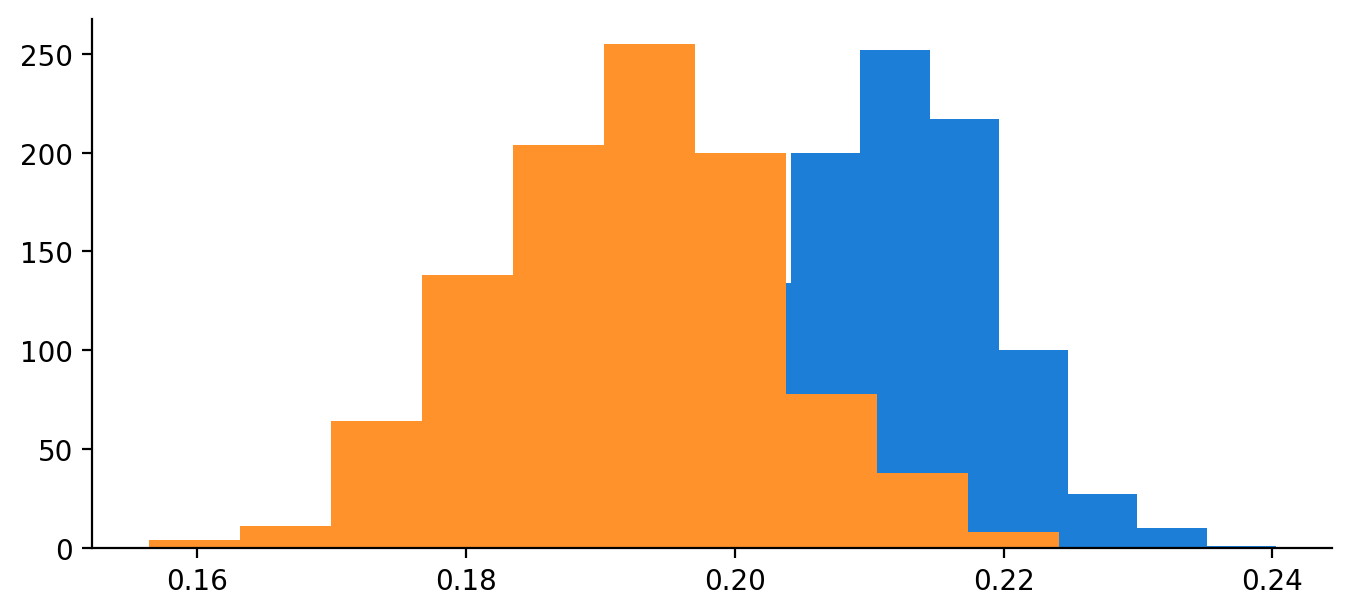

In [283]:
plt.hist(bs_spearman)
plt.hist(bs_pearson)


In [271]:
from bgspy.bootstrap import pivot_ci

lower, upper = pivot_ci(bs_spearman, spearman_est)
lower, spearman_est, upper

(0.1947125324732342, 0.21099378519515583, 0.22449635946944738)

In [285]:

lower, upper = pivot_ci(bs_pearson, pearson_est)
lower, pearson_est, upper

(0.16940682104535684, 0.19107139860951688, 0.20970391585281126)

### Prediction Model Fits

These are all here for completeness, but the important summary are the graphics in the next session.

In [51]:
import statsmodels.formula.api as smf
import statsmodels as sm

models = {}

site_types = ('total', 'syn', 'nonsyn')

for stype in site_types:
    models[stype] = {'pred_subrate + gc': smf.ols(f'{stype}_prop ~ r_rs_year + gc', data=do).fit(),
                    'pred_subrate': smf.ols(f'{stype}_prop ~ r_rs_year', data=do).fit(),
                    'gc': smf.ols(f'{stype}_prop ~ gc', data=do).fit()}

In [52]:
for model, res in models['syn'].items():
    print(f"\n########### {model} ###########\n")
    print(res.summary())


########### pred_subrate + gc ###########

                            OLS Regression Results                            
Dep. Variable:               syn_prop   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     129.8
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           1.15e-56
Time:                        21:56:42   Log-Likelihood:                 57547.
No. Observations:               16316   AIC:                        -1.151e+05
Df Residuals:                   16313   BIC:                        -1.151e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [53]:
for model, res in models['nonsyn'].items():
    print(f"\n########### {model} ###########\n")
    print(res.summary())


########### pred_subrate + gc ###########

                            OLS Regression Results                            
Dep. Variable:            nonsyn_prop   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     355.8
Date:                Sun, 15 Jan 2023   Prob (F-statistic):          5.60e-152
Time:                        21:56:42   Log-Likelihood:                 74632.
No. Observations:               16316   AIC:                        -1.493e+05
Df Residuals:                   16313   BIC:                        -1.492e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [54]:
for model, res in models['total'].items():
    print(f"\n########### {model} ###########\n")
    print(res.summary())


########### pred_subrate + gc ###########

                            OLS Regression Results                            
Dep. Variable:             total_prop   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     351.1
Date:                Sun, 15 Jan 2023   Prob (F-statistic):          5.00e-150
Time:                        21:56:42   Log-Likelihood:                 71787.
No. Observations:               16316   AIC:                        -1.436e+05
Df Residuals:                   16313   BIC:                        -1.435e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [55]:
for stype in site_types:
    print(f"## {stype} ##")
    print(sorted({m: r.aic for m, r in models[stype].items()}.items(), key=lambda x: x[1] ))
    print("\n")

## total ##
[('pred_subrate + gc', -143567.40839077177), ('pred_subrate', -143488.5416917804), ('gc', -143093.33131555014)]


## syn ##
[('pred_subrate + gc', -115087.33928260871), ('pred_subrate', -114995.1663387873), ('gc', -114987.67230768179)]


## nonsyn ##
[('pred_subrate + gc', -149257.83093936084), ('pred_subrate', -149256.46266610333), ('gc', -148628.7972496686)]




### Model Prediction Checks and Graphics

Note: I narrow the x-axis a bit; part of the purpose of the figure is to show the good fit of the model, but this just shows the tail of high GC windows.

In [151]:
import warnings
from sklearn.model_selection import KFold, LeaveOneOut
from collections import defaultdict

warnings.filterwarnings(action='once')


def bin_kfolds(x, y, bins=np.arange(5, 100, 2), n_splits=100, **bin_args):
    kf = KFold(n_splits=n_splits)
    mses = defaultdict(list)
    cv_mses = []
    nbs = []
    
    bin_range = (x.min(), 1.001*x.max()) # to include the right side
        
    def safe_mean(x):
        if not len(x) or np.all(~np.isfinite(x)):
            return np.nan
        return np.nanmean(x)

    for nb in bins.astype(int):
        for train, test in kf.split(x):
            # cut bins
            bins = cutbins(x[train], nb, xrange=bin_range, **bin_args)

            # train: bin based on training data
            bin_means = binned_statistic(x[train], y[train], statistic=safe_mean, bins=bins)
            
            # get the number of elements per bin
            bin_ns = binned_statistic(x[train], y[train], statistic=lambda x: np.sum(np.isfinite(x)), bins=bins)
            
            # take the test data and bin it
            idx = np.digitize(x[test], bins)
            
            # estimate the squared error of predictions
            se = (bin_means.statistic[idx-1] - y[test])**2
            
            # we weight the MSE by the bin sizes
            weights = bin_ns.statistic[idx-1]
            keep = np.isfinite(se)
            mse = np.average(se[keep], weights=weights[keep])
            
            mses[nb].append(mse)
            cv_mses.append(mse)
            nbs.append(nb)
            
    msedat = {nb: np.mean(v) for nb, v in mses.items()}
    return list(msedat.keys()), list(msedat.values())
    

In [152]:
kf_res_quantile = bin_kfolds(do['r_rs_year'], do['total_prop'], method='quantile')

In [167]:
kf_res_interval = bin_kfolds(do['r_rs_year'], do['total_prop'], bins=np.arange(5, 100, 1))

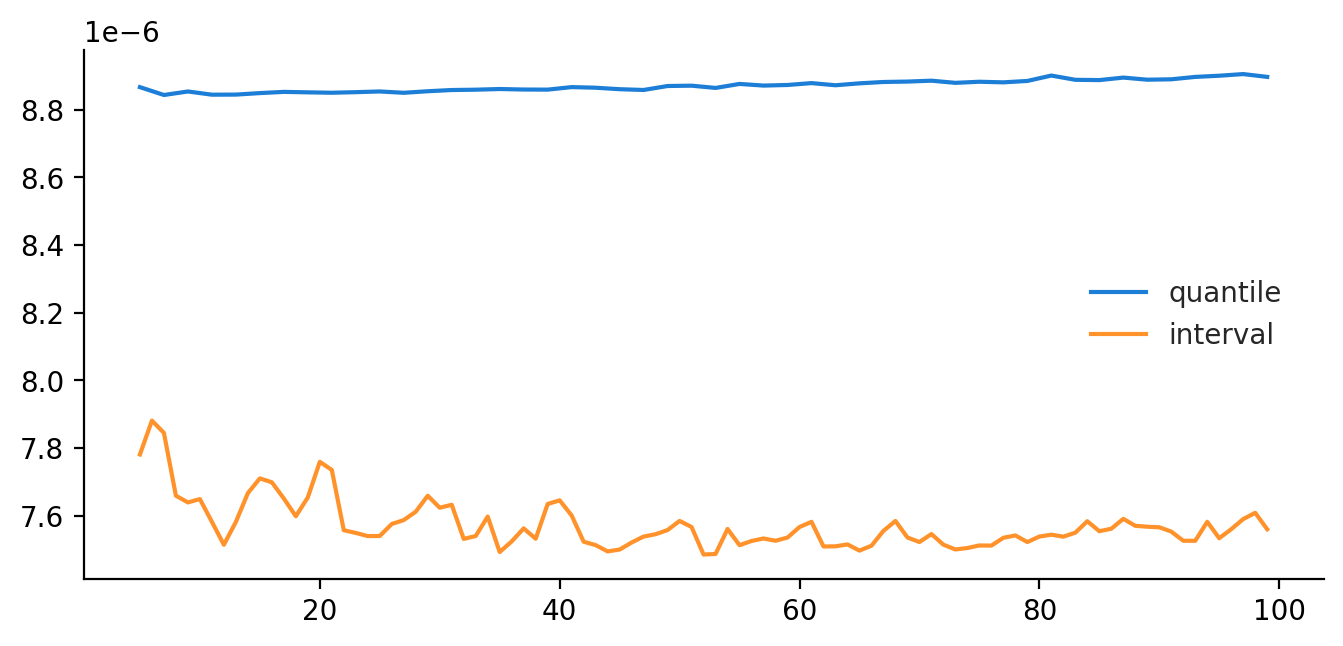

In [168]:
plt.plot(*kf_res_quantile, label='quantile')
plt.plot(*kf_res_interval, label='interval')
plt.legend()

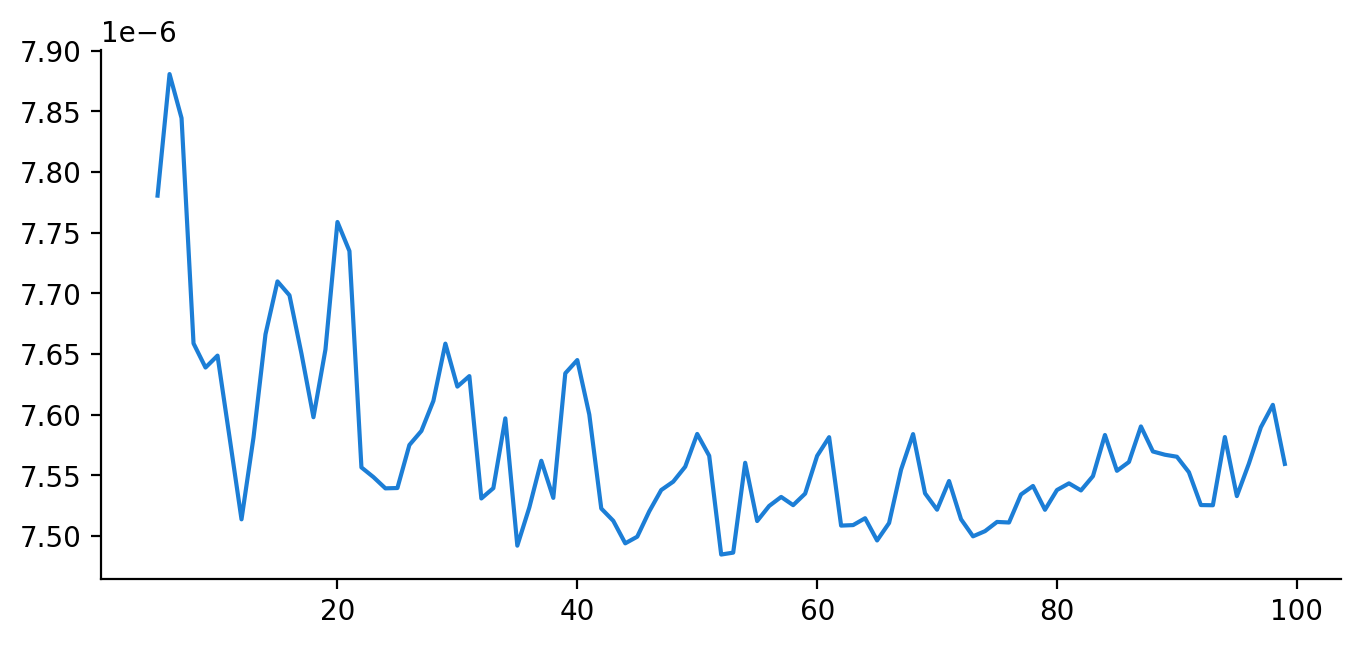

In [169]:
plt.plot(*kf_res_interval)

In [170]:
kf_res_interval[0][np.argmin(kf_res_interval[1])]

52

In [179]:
nbin = 52

Note: we thin the number of bins shown for visualize clarity.

<>:2: DeprecationWarning: invalid escape sequence \h
/tmp/ipykernel_36179/2844014365.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gcdf = do.groupby('bins')['r_rs_year', 'gc', 'total_prop'].mean().reset_index()


(0.0011821895420961403, 0.006)

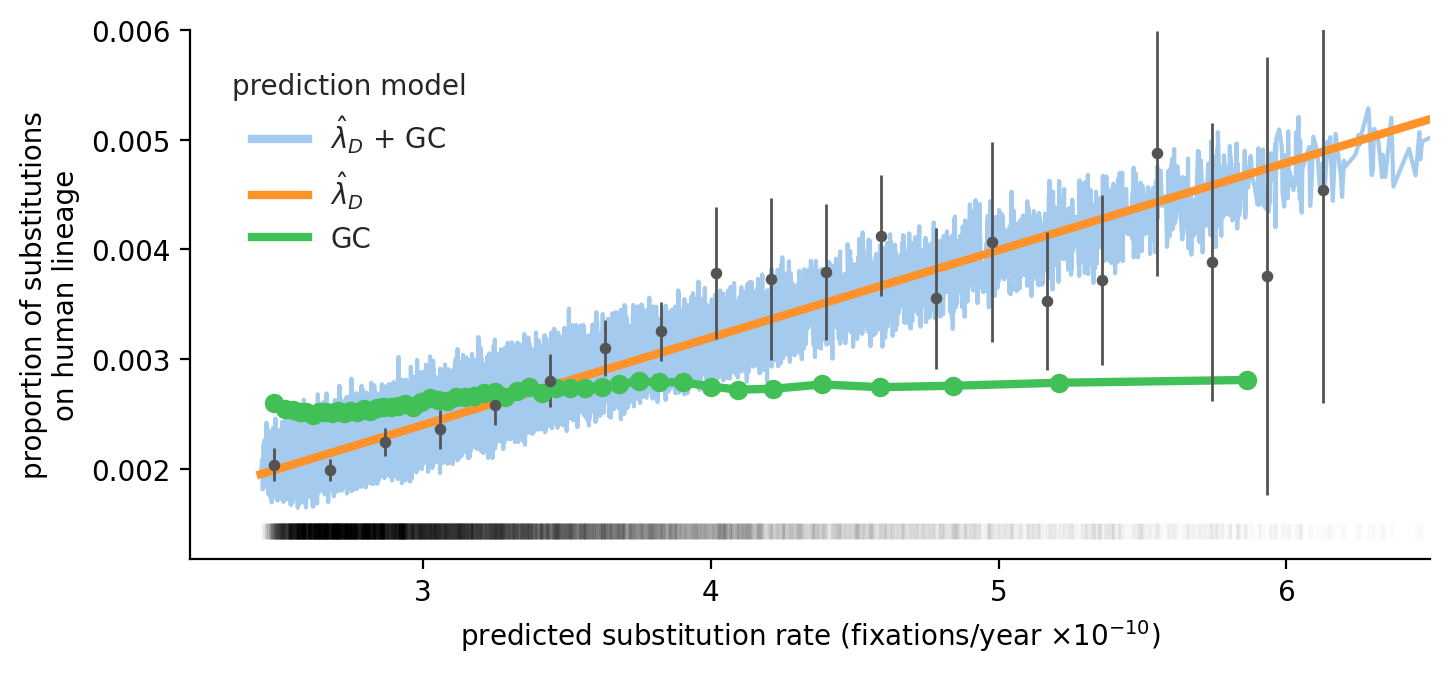

In [193]:
#fancy_labels = {'pred_subrate + gc': "$\widehat{\lambda}_D$ + GC", 'pred_subrate': "$\widehat{\lambda}_D$", 'gc': 'GC'}
fancy_labels = {'pred_subrate + gc': "$\hat{\lambda}_D$ + GC", 'pred_subrate': "$\hat{\lambda}_D$", 'gc': 'GC'}

fig, ax = plt.subplots()

for model, res in models['total'].items():
    label = fancy_labels[model]
    if model == 'gc':
        do['bins'] = pd.qcut(do['r_rs_year'], 50)
        gcdf = do.groupby('bins')['r_rs_year', 'gc', 'total_prop'].mean().reset_index()
        intercept, slope = res.params
        gcdf['pred'] = res.predict(pd.DataFrame(dict(gc=gcdf['gc'])))
        lines = ax.plot(gcdf['r_rs_year'], gcdf['pred'], label=label, linewidth=3)
        ax.scatter(gcdf['r_rs_year'], gcdf['pred'], c=lines[0].get_color(), zorder=3)
    else:
        f = res.model
        exog_names = np.array(f.exog_names)
        x = f.exog[:, exog_names == 'r_rs_year'].flat
        y = res.fittedvalues.values
        idx = np.argsort(x)
        alpha = 0.4 if model == 'pred_subrate + gc' else 1
        ax.plot(x[idx], y[idx].flat, label=label, alpha=alpha, linewidth={'pred_subrate': 3}.get(model, 1.5))

leg = ax.legend(title='prediction model')

ax.plot(do['r_rs_year'], [ax.get_ylim()[0]]*len(do), '|', color='k', alpha=0.01)
#binned_means_plot(binned_summaries(do['r_rs_year'], do['total_prop'], 30, method='number'), figax=(fig, ax), linewidth=1, s=10, c='0.22')
binned_means_plot(binned_summaries(do['r_rs_year'], do['total_prop'], nbin), figax=(fig, ax), linewidth=1, s=10, c='0.33', thin=2, min_n=10)

leg.legendHandles[0].set_linewidth(3)

break_pt = 5.55e-10
#ax.axvline(break_pt, linestyle='dashed', c='0.44', zorder=-20)
#frac_data_below = (do['r_rs_year'] < 4.7e-10).mean()
#ax.text(break_pt*0.99, 0.0055, f"{int(np.round(100*frac_data_below))}% of genes", horizontalalignment='right')
#ax.annotate("", xy=(break_pt*0.8, 0.0054), xytext=(break_pt, 0.0054), ha="center", arrowprops=dict(arrowstyle="-|>", color='0.22'))

xticks = ax.axes.get_xticks()[1:]
ax.axes.set_xticks([x for x in xticks])
ax.axes.set_xticklabels([pretty_signif(x*1e10) for x in xticks])


ax.set_ylabel("proportion of substitutions\non human lineage")
ax.set_xlabel("predicted substitution rate (fixations/year $\\times 10^{-10}$)")

ax.set_xlim(ax.get_xlim()[0], 6.5e-10)
ax.set_ylim(ax.get_ylim()[0], 0.006)

/tmp/ipykernel_36179/1407114972.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gcdf = do.groupby('bins')['r_rs_year', 'gc', 'nonsyn_prop'].mean().reset_index()


(<Figure size 1600x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'non-synonymous'}>)

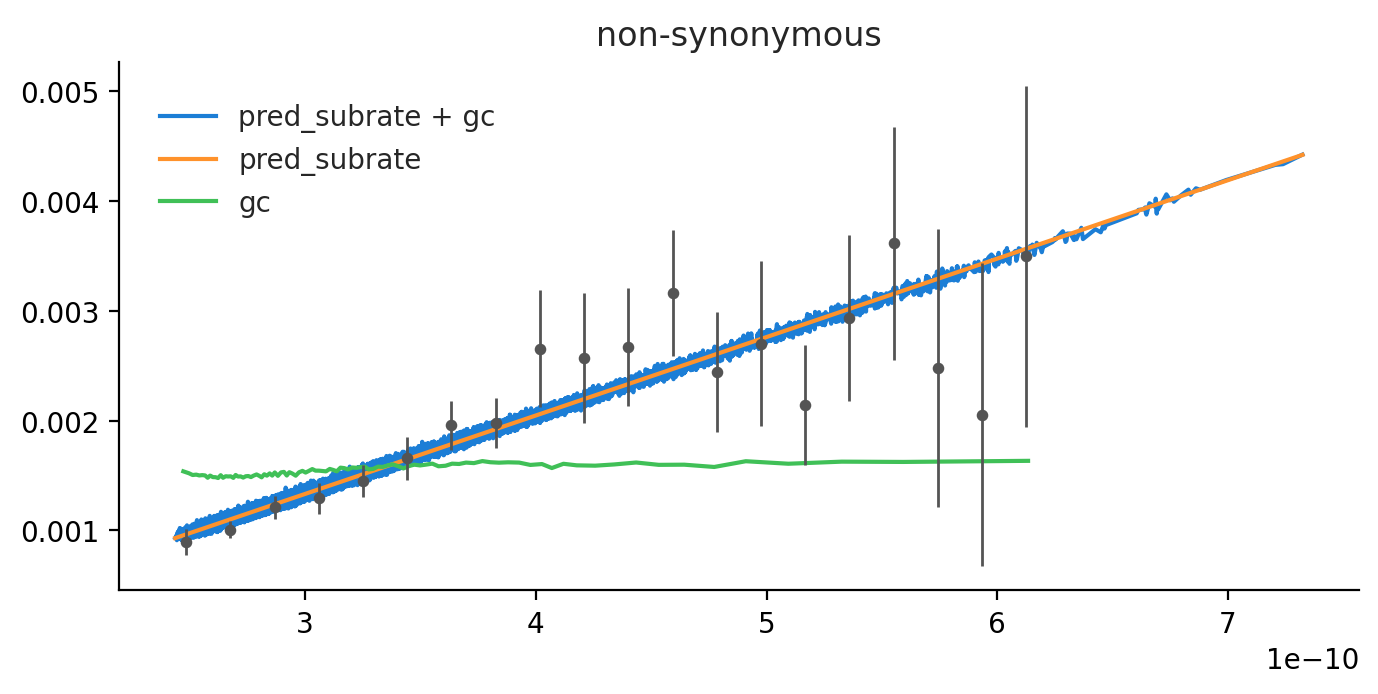

In [197]:
fig, ax = plt.subplots()
ax.set_title("non-synonymous")

for model, res in models['nonsyn'].items():
      
    if model == 'gc':
        do['bins'] = pd.qcut(do['r_rs_year'], 100)
        gcdf = do.groupby('bins')['r_rs_year', 'gc', 'nonsyn_prop'].mean().reset_index()
        intercept, slope = res.params
        gcdf['pred'] = res.predict(pd.DataFrame(dict(gc=gcdf['gc'])))
        plt.plot(gcdf['r_rs_year'], gcdf['pred'], label=model)
    else:
        f = res.model
        exog_names = np.array(f.exog_names)
        x = f.exog[:, exog_names == 'r_rs_year'].flat
        y = res.fittedvalues.values
        idx = np.argsort(x)
        ax.plot(x[idx], y[idx].flat, label=model)

ax.legend()

binned_means_plot(binned_summaries(do['r_rs_year'], do['nonsyn_prop'], nbin), figax=(fig, ax), linewidth=1, s=10, c='0.33', thin=2, min_n=10)


/tmp/ipykernel_36179/2162700510.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gcdf = do.groupby('bins')['r_rs_year', 'gc', 'syn_prop'].mean().reset_index()


(<Figure size 1600x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'synonymous'}>)

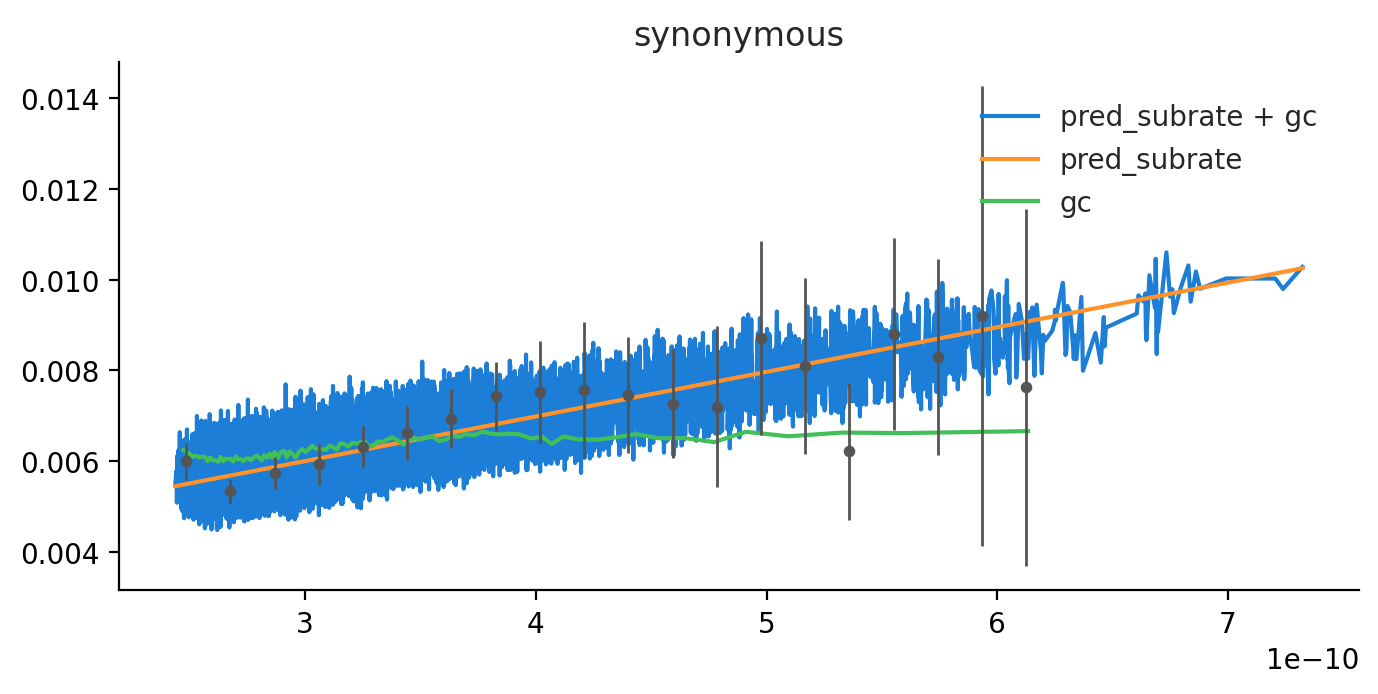

In [199]:
fig, ax = plt.subplots()
ax.set_title("synonymous")
for model, res in models['syn'].items():
      
    if model == 'gc':
        do['bins'] = pd.qcut(do['r_rs_year'], 100)
        gcdf = do.groupby('bins')['r_rs_year', 'gc', 'syn_prop'].mean().reset_index()
        intercept, slope = res.params
        gcdf['pred'] = res.predict(pd.DataFrame(dict(gc=gcdf['gc'])))
        plt.plot(gcdf['r_rs_year'], gcdf['pred'], label=model)
    else:
        f = res.model
        exog_names = np.array(f.exog_names)
        x = f.exog[:, exog_names == 'r_rs_year'].flat
        y = res.fittedvalues.values
        idx = np.argsort(x)
        ax.plot(x[idx], y[idx].flat, label=model)

ax.legend()

binned_means_plot(binned_summaries(do['r_rs_year'], do['syn_prop'], nbin), figax=(fig, ax), linewidth=1, s=10, c='0.33', thin=2, min_n=10)


### KDE Plots

#### Plot Function

In [219]:
import seaborn as sns
from bgspy.utils import pretty_signif


def sub_kde_plot(pred, prop_sub, T_HCs=None, nbins=None, thin=None, xlim=None, ylim=None, 
                 T_lw=1.1, fit_lw=1.1, tick_fontsize=10, xaxis_scaler=None,
                 show_outliers=True,  fit=True, T_HC_labx=None,
                 cmap="Reds", label_size=8, figax=None):
    fig, ax = get_figax(figax)
    plt.tight_layout(w_pad=0.01)
    
    xx, yy = pred, prop_sub
    keep = prop_sub > 0
    xx, yy = xx[keep], yy[keep]
    kde = sns.kdeplot(x=xx, y=yy, cmap=cmap, shade=True, bw_adjust=.5, ax=ax, log_scale=(None, 10), 
                      alpha=1, bw_method=0.3)
    
    kde_layers = [c for c in kde.get_children() if isinstance(c, mpl.collections.PathCollection)]
    if show_outliers:
        ax.scatter(x=xx, y=yy, s=0.2, c=kde_layers[-3].get_facecolor(), zorder=-10, alpha=0.1)
    
    xl = ax.get_xlim()
    rate_grid = np.linspace(xl[0], xl[1], 100)
    
    # plot the fit
    if fit:
        # fit a simple model here
        slope, intercept, r, p, se = stats.linregress(xx, yy)            
        ax.plot(rate_grid, intercept + slope*rate_grid, c='orange', linewidth=fit_lw)        
        
    if nbins is not None:
        df = binned_summaries(xx, yy, nbins=nbins)
        c = '0.55'
        x = df['midpoint'].values
        n = df['n'].values
        stat = 'mean'
        linewidth = 0.8
        mean, sd = df[stat].values, df['sd'].values
        ax.scatter(x[::thin], mean[::thin], c=c, s=1, alpha=1, zorder=10)
        ax.errorbar(x[::thin], mean[::thin], (2*sd/np.sqrt(n))[::thin], fmt='none', c=c, elinewidth=linewidth)
    
    if T_HCs is not None:
        for i, T in enumerate(sorted(T_HCs)):
            ax.plot(rate_grid, T*rate_grid, c='0.33', 
                    linestyle='dashed', linewidth=T_lw)
            if T_HC_labx is not None:
                labx = T_HC_labx
                j = np.argmin(np.abs(rate_grid - labx))
                ypos = T*rate_grid[j]
                #offset = np.log10(ypos) * 1e-5
                #offset = -10 * offset if i == 0 else offset
                val = pretty_signif(T/1e6)
                rise, run = ((T*rate_grid[j+1] - T*rate_grid[j-1])), (rate_grid[j+1] - rate_grid[j-1])

                b = np.rad2deg(np.arctan2(rise, run))

                angle_screen = ax.transData.transform_angles((b, ), np.array([labx, ypos]).reshape(1, 2))[0]
                valn = 'top' if i == 1 else 'bottom'
                # ax.text(labx, ypos, f"$T_{{HC}} = {val}$ Mya", 
                #         horizontalalignment='center',
                #         verticalalignment=valn,
                #         rotation=b_screen[0], fontsize=label_size)
                offset = -1 if i == 0 else 1
                va = 'bottom' if i == 1 else 'top'
                ax.annotate(f"$T_{{HC}} = {val}$ Mya", 
                            xy=(labx, ypos), xytext=(0, offset), textcoords="offset points", 
                            ha='center', va=va,
                            rotation_mode='anchor', rotation=angle_screen, fontsize=label_size)

    if tick_fontsize is not None:
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        

    if xlim is not None:
        xlim = list(xlim)
        if xlim[0] is None:
            xlim[0] = xl[0]
        if xlim[1] is None:
            xlim[1] = xl[1]            
        ax.set_xlim(*xlim)

    if ylim is not None:
        yl = list(ax.get_ylim())
        ylim = list(ylim)
        if ylim[0] is None:
            ylim[0] = yl[0]
        if ylim[1] is None:
            ylim[1] = yl[1]            
        ax.set_ylim(*ylim)
    
    if xaxis_scaler is not None:
        xticks = ax.axes.get_xticks()[1:]
        ax.axes.set_xticks([x for x in xticks])
        ax.axes.set_xticklabels([pretty_signif(x*xaxis_scaler) for x in xticks])
    
    return fig, ax

#### Substitution Proportions by Predicted Substitution Rates

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1165: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.3":
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/seaborn/_core.py:1165: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.3":
/home/vsb/miniconda3/envs/bprime/lib/pytho

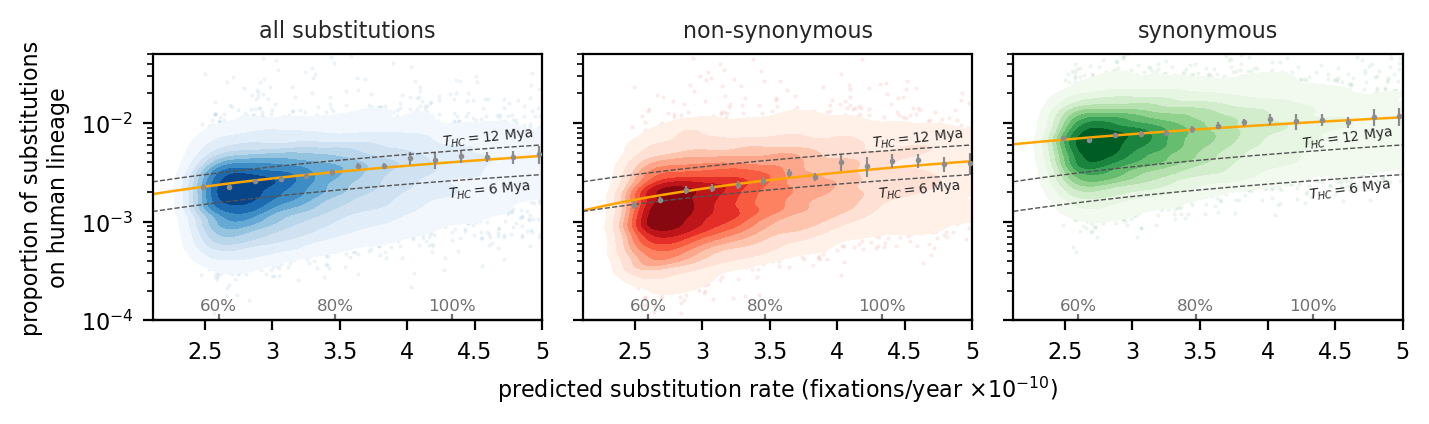

In [222]:
lw = 0.5
flw = 0.9
tfs = 6
ls = 5
lax = 4.6e-10

T_HCs_np = np.array(T_HCs)

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(7, 2))

sub_kde_plot(x_rs, syn_prop, T_HCs=T_HCs_np, xlim=(None, 5e-10), 
             cmap='Greens', 
             xaxis_scaler=1e10,
             nbins=nbin,
             thin=2,             
             T_HC_labx=lax,
             label_size=ls,
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(1e-3, 5e-2), 
             figax=(fig, ax[2]))
sub_kde_plot(x_rs, nonsyn_prop, T_HCs=T_HCs_np, xlim=(None, 5e-10), 
             nbins=nbin,
             thin=2,             
             xaxis_scaler=1e10,
             label_size=ls,
             T_HC_labx=lax,             
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(1e-4, 5e-2), 
             figax=(fig, ax[1]))
sub_kde_plot(x_rs, total_prop, T_HCs=T_HCs_np, xlim=(None, 5e-10), 
             nbins=nbin,   
             thin=2,
             xaxis_scaler=1e10,
             label_size=ls,
             T_HC_labx=lax,             
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(2e-4, 4e-2), 
             cmap='Blues', figax=(fig, ax[0]))

ax[0].set_ylabel("proportion of substitutions\non human lineage")
ax[1].set_ylabel("")
ax[2].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("predicted substitution rate (fixations/year $\\times 10^{-10}$)")
ax[2].set_xlabel("")

ax[2].set_title("synonymous")
ax[1].set_title("non-synonymous")
ax[0].set_title("all substitutions")


def scale_neutral(sub):
    gen_time = 30
    neut_mu_years = 1.3e-8 / gen_time
    return 100 * sub/neut_mu_years

def neutral_to_sub(neut):
    return neut



label_fontsize = 8
for fax in ax:
    if label_fontsize is not None:
        for item in [fax.title] + fax.get_xticklabels() + fax.get_yticklabels():
            item.set_fontsize(label_fontsize)
        fax.xaxis.label.set_fontsize(label_fontsize)
        fax.yaxis.label.set_fontsize(label_fontsize)

sec_x = [None, None, None]
for i in range(3):
    sec_x[i] = ax[i].secondary_xaxis('bottom', functions=(scale_neutral, neutral_to_sub))
    for item in sec_x[i].get_xticklabels():
        item.set_fontsize(6)
        item.set_color('0.44')
    sec_x[i].tick_params(axis="x", direction="in", pad=-8, length=2, color='0.44')
    sec_x[i].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))

    
    ax[i].spines['right'].set_visible(True)
    ax[i].spines['top'].set_visible(True)
    
#ax[2].axhline((1.3e-8 / gen_time) * T_HCs[0], linestyle='dashed', c='0.33', linewidth=lw)
#ax[2].axhline((1.3e-8 /gen_time) * T_HCs[1], linestyle='dashed', c='0.33', linewidth=lw)


for i in range(3):
    ax[0].set_ylim(1e-4, 5.04e-2)

#plt.savefig('../manuscript/figures/sub_figure.pdf')

Check of the x-axis:

In [228]:
# estimated substitutions on human branch for different 
MU * (np.array(T_HCs) * u.year)

unyt_array([0.0026, 0.0052], 'mutations')

In [230]:
# under neutrality, substitution rate is mutation rate
neutral_subrate = MU
neutral_subrate, neutral_subrate.to('mutations/year')

(unyt_quantity(1.3e-08, 'mutations/human_gen'),
 unyt_quantity(4.33333333e-10, 'mutations/yr'))

In [231]:
# what's the average predicted ratchet rate in mutations/human generation?

cds_subrate = do['r_rs'].mean() * (u.mutations/u.human_gen)
cds_subrate, cds_subrate.to('mutations/year'), cds_subrate.to('mutations/year') / neutral_subrate

(unyt_quantity(9.91591974e-09, 'mutations/human_gen'),
 unyt_quantity(3.30530658e-10, 'mutations/yr'),
 unyt_quantity(0.76276306, '(dimensionless)'))

This matches the x-axis scale of the plots above, in fixations / year

Quick look at how DFE and implied neutral/nearly neutral sites:

In [232]:
W = bpfit_sm.mle_W 
np.round(W, 2)

array([[0.02, 0.05, 0.48],
       [0.19, 0.13, 0.03],
       [0.2 , 0.05, 0.13],
       [0.05, 0.02, 0.1 ],
       [0.13, 0.19, 0.17],
       [0.25, 0.35, 0.05],
       [0.17, 0.21, 0.05]])

In [233]:
Ns = bpfit_sm.t * 10_000 
can_fix = Ns > 1
Ns, can_fix

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 array([False, False, False, False,  True,  True,  True]))

In [234]:
W[can_fix, np.array(bpfit_sm.features) == 'cds'].sum()

0.5442121074307021

So ~54% of mutations could possibly fix. The actual rate is much lower.

### Bar plot of Effects

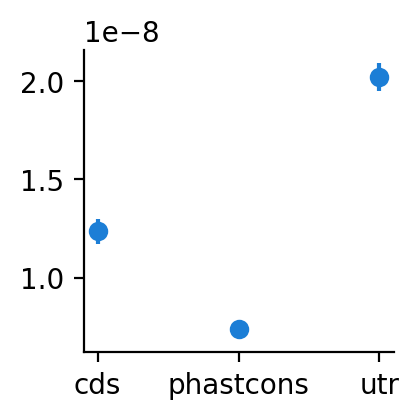

In [238]:
sr_stats = dsr_rs.groupby(['feature'], as_index=False).agg({'r_rs': ['mean', 'std']}).reset_index()

fig, ax = plt.subplots(figsize=(2, 2))
ax.errorbar(sr_stats[('feature', '')], sr_stats[('r_rs', 'mean')], 2*sr_stats[('r_rs', 'std')], fmt='none')
ax.scatter(sr_stats[('feature', '')], sr_stats[('r_rs', 'mean')])

In [336]:
dsr.loc[dsr['feature'] == 'utr', 'r_rs']

314        1.991556e-08
315        1.991684e-08
328        1.997122e-08
1929       1.995594e-08
1935       1.993759e-08
               ...     
7647014    1.995340e-08
7647015    1.994999e-08
7647016    1.995625e-08
7647017    1.996358e-08
7647018    1.997166e-08
Name: r_rs, Length: 194070, dtype: float64

<SecondaryAxis: >

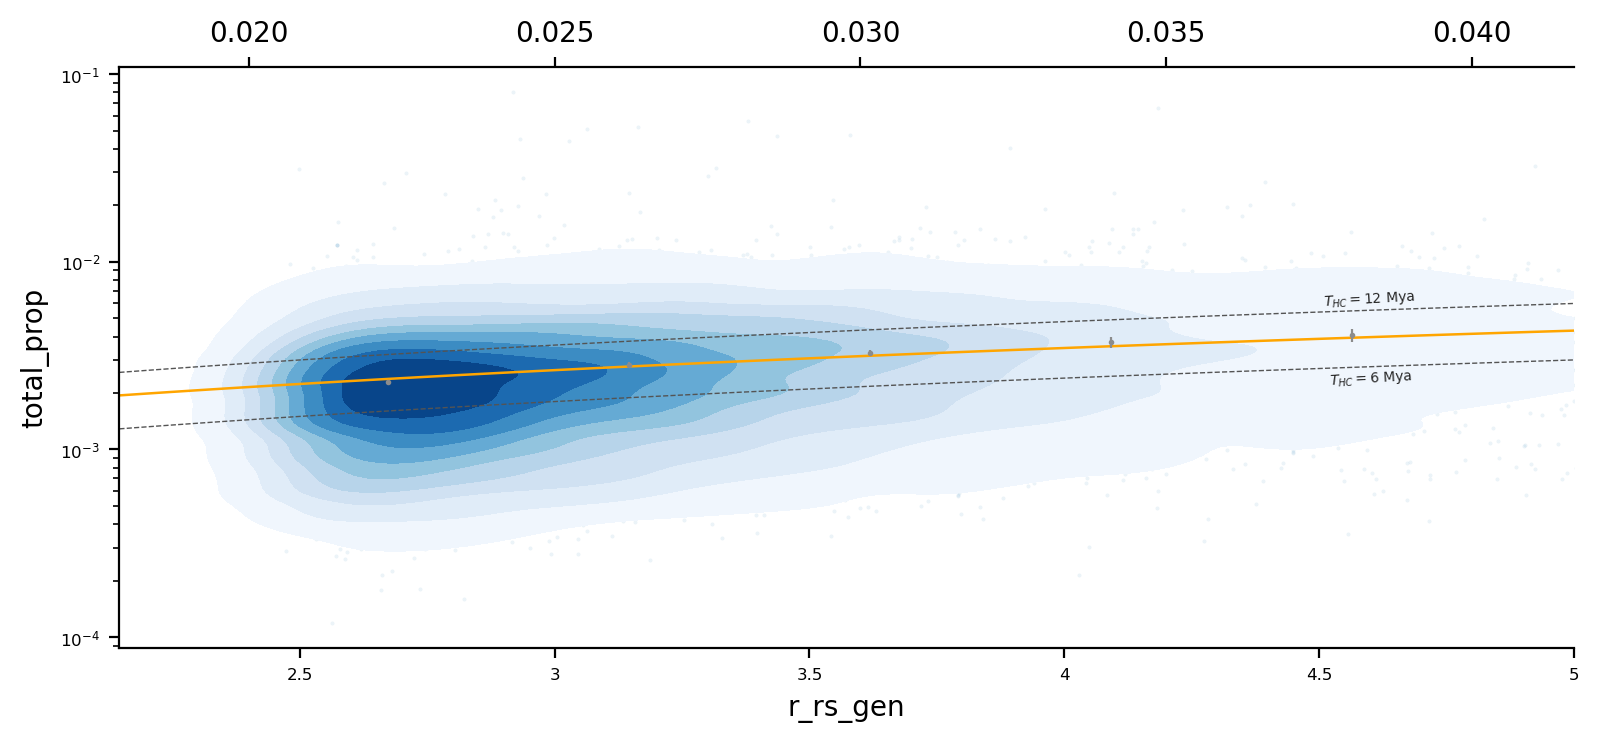

In [102]:
## random test plot, for experiments

fig, ax = plt.subplots()
sub_kde_plot(x_rs, total_prop, T_HCs=T_HCs, xlim=(None, 5e-10), 
             nbins=10,   
             xaxis_scaler=1e10,
             label_size=ls,
             T_HC_labx=lax,             
             T_lw=lw, fit_lw=flw,
             tick_fontsize=tfs,
             #ylim=(2e-4, 4e-2), 
             cmap='Blues', figax=(fig, ax))

ax.secondary_xaxis('top', functions=(scale_neutral, neutral_to_sub))

In [558]:
## some quick calcs I always forget


# assumiming 6.5e6 divergence time implies a mutation rate of 

1e-9 # subs/year from Moorjani et al 2016

1e-9 * gen_time# x (gen years/gen)

3.0000000000000004e-08

This is two-fold higher than pedigree estimates as Moorjani et al. (2016) explain.

/tmp/ipykernel_37014/2039554002.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim((0, 0.2e-6))


(2.0653388862371308e-10, 2e-07)

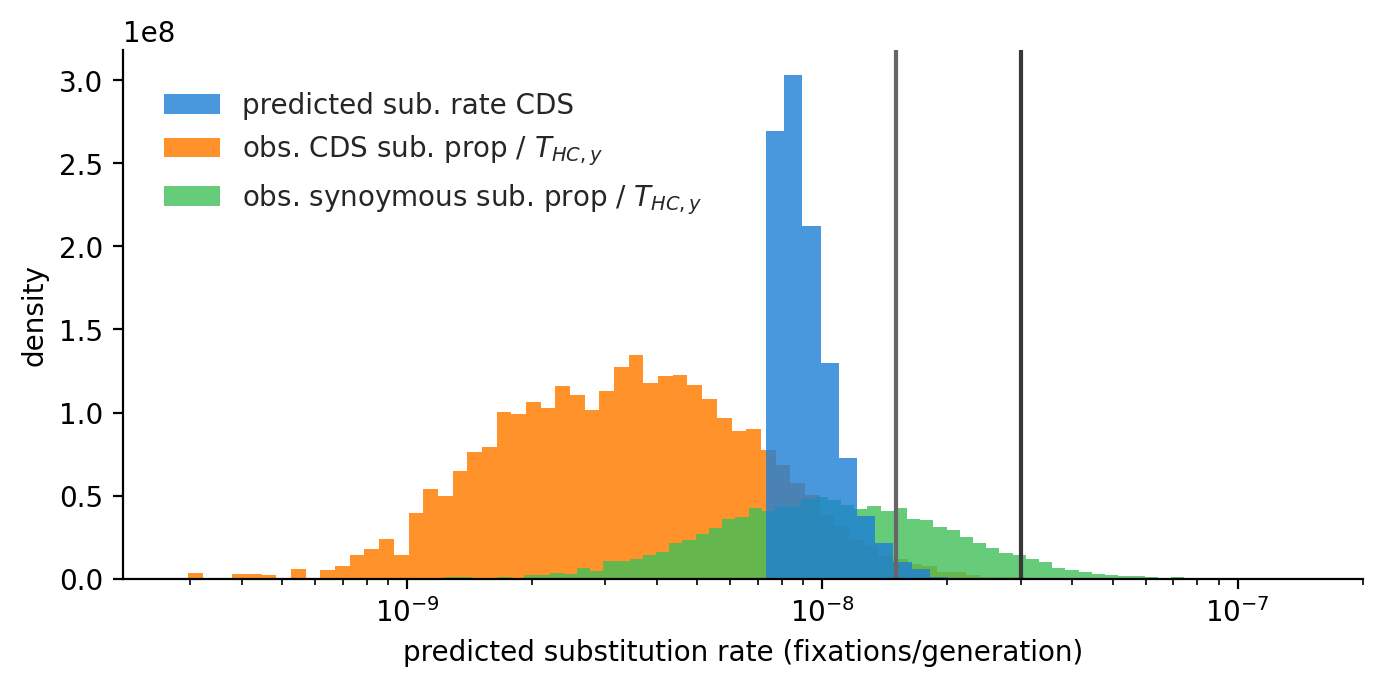

In [559]:
xscaler = 1e9

fig, ax = plt.subplots()
ax.hist(*logbins(do['r_rs'].values, 10), density=True, label='predicted sub. rate CDS', zorder=2, alpha=0.8)
#ax.hist(*logbins(dutr['r_rs'].values, 10), density=True, label='predicted sub. rate UTRs', zorder=2)

implied_subrate_gen = gen_time*do['total_prop'].values/(12e6)
implied_subrate_gen = implied_subrate_gen[implied_subrate_gen > 0]
ax.hist(*logbins(implied_subrate_gen, 80), density=True, label='obs. CDS sub. prop / $T_{HC,y}$')

implied_subrate_syn_gen = gen_time*do['syn_prop'].values/(12e6)
implied_subrate_syn_gen = implied_subrate_syn_gen[implied_subrate_syn_gen > 0]
ax.hist(*logbins(implied_subrate_syn_gen, 80), density=True, label='obs. synoymous sub. prop / $T_{HC,y}$', alpha=0.8)

ax.semilogx()
ax.axvline(3e-8, c='0.22')
ax.axvline(1.5e-8, c='0.4')
ax.set_ylabel("density")
#ax.set_xlabel(f"predicted substitution rate (fixations/year $\\times 10^{{{int(np.log10(xscaler))}}}$)")
ax.set_xlabel(f"predicted substitution rate (fixations/generation)")# $\\times 10^{{{int(np.log10(xscaler))}}}$)")
#ax.set_xlim((-2.8e-09, 5.91e-08))
ax.legend(loc='upper left')
ax.set_xlim((0, 0.2e-6))

### Rough Estimates of the Fraction of Sites Capable of Alternative

Some back-of-the-envelope calculations on the possible estimate of the substitutional sieve.



In [286]:


xx, yy = x_rs, total_prop
keep = total_prop > 0
xx, yy = xx[keep].values, yy[keep].values
all_subs_lm = stats.linregress(xx, yy)

slope, intercept, r, p, se = all_subs_lm
all_subs_lm

LinregressResult(slope=9487227.804728378, intercept=-0.00010238410933891603, rvalue=0.2241335523538407, pvalue=1.4270384415394934e-161, stderr=345749.53535551176, intercept_stderr=0.00011683983720024749)

$$
K = T \beta (\lambda_d + \lambda_b)
$$

Our predictions are $\lambda_d$ estimates; hereafter these are $x$ to indicate that we treat them as the x in a linear regression.
Also, we denote $y = K$ as $y$ is the proportion of substitutions on the human lineage.

Assuming $\lambda_d >> \lambda_b$,

$$
y =  \beta T x
$$

we define $\gamma = \beta T$ as the slope parameter. Our estimate is

$$
y = \gamma x + c 
$$
 
where we use $c$ as an extra degree of freedom to better estimate the slope. 

Then, a rough estimotor of $\hat{\beta}$ is 

$$
\hat{\beta} = \hat{\gamma}/T
$$

In [309]:
beta = slope / T_HCs
beta

array([1.64144275, 0.82072138])

Now let's do a bootstrap of this.

In [288]:
nboot = 10000


bs_slopes = np.zeros(nboot, dtype='int')
for b in range(nboot):
    idx = np.random.randint(0, len(yy), len(yy))
    boot_lm = stats.linregress(xx[idx], yy[idx])
    slope, intercept, r, p, se = boot_lm
    bs_slopes[b] = slope

In [289]:
T_HCs = np.array(T_HCs)

In Pollard et al. (2010), they estimate the fraction of conserved sites for different classes of sites. For the first, second, third positions of codons, they report the following fractions (Figure 4C). The emphasize this is a lower bound and approximate though in the caption.

In [314]:
pollard_cds_cons_est = (np.array([65.5, 70.8, 24.6])/100).mean()
pollard_cds_cons_est

0.5363333333333333

Table 1 of Davydov et al (2010) suggests that 84.6% percent of exons are covered by a consered element.

In [317]:
davydov_cds_cons_est = 84.6 / 100

What are the split times implied by these estimtes?

In [320]:
np.array([slope / pollard_cds_cons_est, slope / davydov_cds_cons_est]) / 1e6

array([18.36293946, 11.64143798])

For phastcons, they report 87.9%. Our CDS include some phascons sites, since we prioritize genomic features. So the fraction above should be weighted by the overlap between phastcons and CDS.

I did the follow rough calculation to estimate the fraction of constrained sites:

```
$ bedtools intersect -b <(bedtools merge -i conserved_phastcons.bed.gz) -a <(bedtools merge -i hg38.ensembl_cds.bed.gz ) | \
    bioawk -cbed 'BEGIN {a=0} {a += $end-$start} END {print a}'

22878020

$ zcat hg38.ensembl_cds.bed.gz | bedtools merge | bioawk -cbed 'BEGIN {a=0} {a += $end-$start} END {print a}'
35615825
```

The overlap estimates are close, 91,486,641 and 91,485,992.

In [291]:
frac_cds_phastcons = 22878020 / 35615825

In [294]:
est_pollard_frac_cons = frac_cds_phastcons * 87.9/100 + (1-frac_cds_phastcons)*0.54

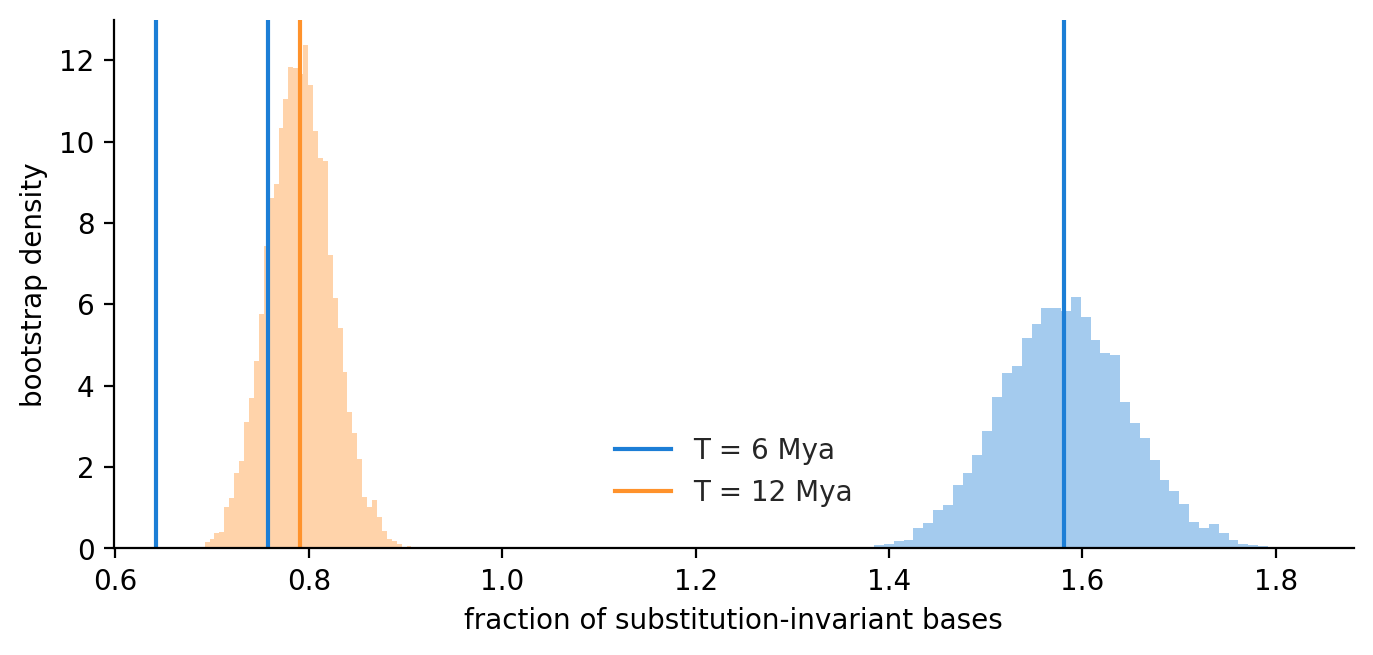

In [295]:
boot_ests = (bs_slopes / T_HCs[:, None]).T

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots()

labs = set()

for i, T in enumerate(T_HCs):
    c = colors[i]
    lines = ax.axvline(beta[i], label=f"T = {int(T/1e6)} Mya", color=c)
    _ = ax.hist(boot_ests[:, i], 50, density=True, color=c, alpha=0.4)

ax.legend()
ax.set_xlabel("fraction of substitution-invariant bases")
ax.set_ylabel("bootstrap density")

ax.axvline(est_pollard_frac_cons)
ax.axvline(frac_cds_phastcons)

## Total Number of Deleterious Mutations

In [296]:
dsr.groupby('feature')['r'].mean()

feature
cds          1.235943e-08
phastcons    7.371133e-09
utr          2.021353e-08
Name: r, dtype: float64

In [297]:
np.exp(dsr_rs.groupby('feature')['load_region'].sum())

feature
cds          0.999660
phastcons    0.929993
utr          0.999775
Name: load_region, dtype: float64

In [308]:
np.exp(dsr_rs['load_region'].sum())

0.9294677984602233

In [301]:
u.define_unit('human_haploid_genome_size', 3e9 * u.counts)

In [302]:
(hs_mu * u.human_haploid_genome_size).to('counts/human_gen')

unyt_quantity(39., 'counts/human_gen')

In [305]:
np.sum(dsr['R'])

2.720003844493329